# Introduction

Feature selection is a crucial step in data preprocessing that aims to identify the most important features contributing to predictive modeling. It helps improve model performance, reduces overfitting, and decreases computational cost by eliminating irrelevant or redundant features.

**Purpose of This Notebook**

This notebook demonstrates basic feature selection techniques that can be applied as initial steps in model development. The methods covered here range from statistical approaches to model-based techniques. To give an idea how handling class imbalance and cross validation affect the results, both results are given. 

**Key Considerations**

- Simplicity vs Complexity - Basic methods, such as correlation analysis and statistical tests, are simple to implement and interpret. They are effective for datasets with fewer features. 

- Computational Requirements - More complex models, like Recursive Feature Elimination (RFE) and Embedded Methods, offer higher accuracy but demand greater computational resources, especially with larger datasets.

- Model Compatibility - Some feature selection techniques depend on the type of model being used (e.g., linear regression vs tree-based models).

In [271]:
# Loading necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and handling arrays
import matplotlib.pyplot as plt  # For visualizing feature importance

# Suppress warnings to avoid clutter in output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)




# Data

In [272]:
# Load the preprocessed dataset from a CSV file
data = pd.read_csv('../data/processed_data.csv')

# Drop the first column, which might be an index column from the original dataset
data = data.drop(data.columns[0], axis=1)  
# axis=1 specifies that we are dropping a column, not a row

# The original dataset is too large, so we randomly sample 5000 cases
# This subsample reduces memory usage and speeds up processing during analysis
# Note: Ensure the subsample file is stored in the workshop folder
data = data.sample(5000, random_state=42)  
# random_state=42 ensures reproducibility of the random sampling

# Save the subsample to a new CSV file for future use
data.to_csv('../data/data.csv', index=False)  
# index=False prevents saving the index column in the output CSV file

# Display the first 5 rows of the dataset to check the structure and contents
data.head()


,cannabis,alcohol,U031D1,U031D6St,U031D3id_1,U031D3id_2,U031D3id_3,U031D3id_4,U031D3id_5,U031D3id_6,...,U031WE26_7,U031WE26_8,U031WE9R,U031WE17R,U031WE18R,U031WE13R,U031WE14R,U031WE15R,U031WE19R,U031WE20R
20777,0.0,1.0,2.0,17.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,1.0,4.0,2.0,4.0,4.0,3.0,1.0
10099,0.0,1.0,1.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,4.0,1.0,4.0,1.0,3.0,2.0,4.0,1.0
890,1.0,1.0,2.0,17.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0
27226,0.0,0.0,1.0,13.4,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,1.0,4.0,2.0,3.0,3.0,2.0,4.0
30913,0.0,0.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,1.0,3.0,2.0,3.0,3.0,1.0,2.0


In [273]:
# Analyze the distribution of cannabis use in the dataset
# 'value_counts()' calculates the frequency of each unique value in the 'alcohol' column
# 'normalize=True' converts the frequencies into proportions (relative frequencies) instead of counts
data['cannabis'].value_counts(normalize=True)


cannabis
0.0    0.8756
1.0    0.1244
Name: proportion, dtype: float64

## Data Split

In [274]:
# Drop 'alcohol' from the dataset 
data.drop('alcohol', axis=1, inplace=True)


data.head()


,cannabis,U031D1,U031D6St,U031D3id_1,U031D3id_2,U031D3id_3,U031D3id_4,U031D3id_5,U031D3id_6,U031D3id_7,...,U031WE26_7,U031WE26_8,U031WE9R,U031WE17R,U031WE18R,U031WE13R,U031WE14R,U031WE15R,U031WE19R,U031WE20R
20777,0.0,2.0,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,1.0,4.0,2.0,4.0,4.0,3.0,1.0
10099,0.0,1.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,4.0,1.0,4.0,1.0,3.0,2.0,4.0,1.0
890,1.0,2.0,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0
27226,0.0,1.0,13.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,1.0,4.0,2.0,3.0,3.0,2.0,4.0
30913,0.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,1.0,3.0,2.0,3.0,3.0,1.0,2.0


In [275]:
# Import train_test_split for splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
# X: Select all columns except the first one (independent variables)
X = data.iloc[:, 1:].values  # Extracts values starting from the second column
# y: Select the first column as the dependent variable (target)
y = data.iloc[:, 0].values  # Extracts values from the first column

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,                 # Input data
    test_size=0.3,        # 30% of data reserved for testing
    random_state=0,       # Ensures reproducibility of the split
    stratify=y            # Maintains the same class distribution in training and testing sets
)


In [276]:
print('Dimension of X train: ', X_train.shape)
print('Target 1: ', np.count_nonzero(y_train == 1))
print('Target 0: ', np.count_nonzero(y_train == 0))



print('\n ---------------------\n')
print('Dimension of X test :', X_test.shape)
print('Target 1: ', np.count_nonzero(y_test == 1))
print('Target 0: ', np.count_nonzero(y_test == 0))




Dimension of X train:  (3500, 154)
Target 1:  435
Target 0:  3065

 ---------------------

Dimension of X test : (1500, 154)
Target 1:  187
Target 0:  1313


## Scaling

Scaling is an important preprocessing step in machine learning to ensure that features are on a similar scale, improving the performance of algorithms that are sensitive to feature magnitudes. Below are three common scaling approaches:

- StandardScaler - Standardizes features by removing the mean and scaling to unit variance. Suitable for algorithms like Support Vector Machines (SVC) and Logistic Regression. 
- MinMaxScaler - Scales features to a fixed range, typically [0, 1]. Useful for algorithms like k-Nearest Neighbors and Neural Networks that rely on distance metrics. 
- RobustScaler - Removes the median and scales data based on the Interquartile Range (IQR), making it robust to outliers. Suitable when data contains extreme values. 




In [277]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# if you want to try Robust scaler
#robust = RobustScaler()
#X_train_std = robust.fit_transform(X_train)
#X_test_std = robust.transform(X_test)

# we will use standart scaler in this demonstration
std= StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)



# Univariate Statistics - Filter Methods

Our main aim to find out statistically significant / meaningful relationship between features and target.

In this part, we will look at the different methods under the filter methods (there also some other models as well).

- Variance Threshold
- KBest models 
- Information gain 

Filter methods, like K-Best and Mutual Information, evaluate features based on their individual relationship with the target variable. They work independently of any model and do not consider class imbalance.

##  Removing features with low variance - Variance Threshold

The Variance Threshold method removes features whose variance falls below a pre-defined cutoff value. It operates on the assumption that features with low variance have limited predictive power, as they do not vary significantly across observations.

**Key Limitation:**
One major limitation of the variance threshold method is that it does not consider the relationship between input features and the output (target) variable. It evaluates features independently.

**Preprocessing Note:**
Before applying variance thresholding, it is important to standardize all features to ensure they are on the same scale. Standardization prevents features with larger scales from dominating the results.

**Implementation in Scikit-learn:**
Scikit-learn provides the VarianceThreshold function to perform variance-based feature selection.

**Default Behavior:**
By default, VarianceThreshold removes only zero-variance features—features that have the same value across all instances.

In [278]:
# Import the VarianceThreshold function from sklearn for feature selection
from sklearn.feature_selection import VarianceThreshold

# Initialize VarianceThreshold with a threshold of 0.2
# Features with variance below 0.2 will be removed
# Default threshold=0 removes only zero-variance features
vth = VarianceThreshold(threshold=0.2)

# Fit the VarianceThreshold model to the standardized training data
vth.fit(X_train_std)  # Computes variance for each feature in the standardized training set

# Retrieve column names starting from the second column (excluding the target variable)
data.columns[1:]  # Displays feature names without modifying the data

# Select features that meet the variance threshold
X_train_vth = X_train_std[:, vth.get_support()]  
# 'get_support()' returns a boolean mask indicating which features are retained

# Since we are working with NumPy arrays, we retrieve the original feature names
d1 = data.columns.tolist()  # Get all column names as a list
d1 = d1[1:]                 # Exclude the target variable ('cannabis') from the list
d1                          # Display the feature names

# Create a DataFrame to display feature variances along with their names
pd.DataFrame(
    {'Feature': d1,             # Feature names
     'Variance': vth.variances_ # Variance values for each feature
     }).sort_values('Variance', ascending=True)  # Sort by variance in ascending order


,Feature,Variance
141,U031WE26_4,1.0
9,U031SV5R,1.0
108,U031PD3R,1.0
86,U031OD7R,1.0
55,U031EI8R,1.0
...,...,...
84,U031OD5R,1.0
13,U031SV10R,1.0
19,U031SV22R,1.0
3,U031D3id_2,1.0


In [279]:
# Check the variance variation
print(vth.variances_.min(), vth.variances_.max())


0.9999999999999046 1.000000000000222


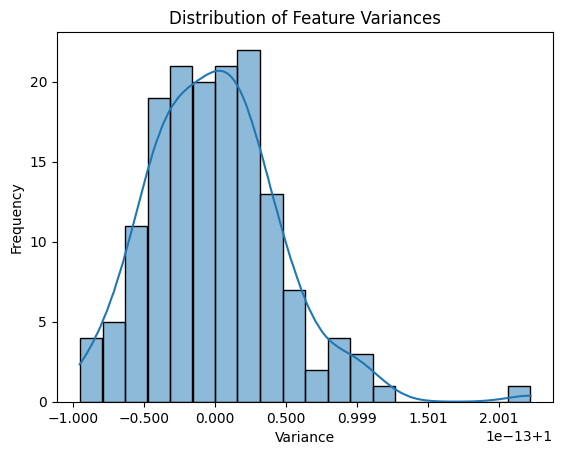

In [280]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of feature variances to evaluate their spread
sns.histplot(vth.variances_, bins=20, kde=True)  # Histogram with 20 bins and density curve (KDE) for smoothing

# Label axes and add title for interpretation
plt.xlabel('Variance')  # X-axis shows variance values of features
plt.ylabel('Frequency') # Y-axis shows the count of features in each variance range
plt.title('Distribution of Feature Variances') # Title for context

plt.show()  # Display the plot to observe variance distribution


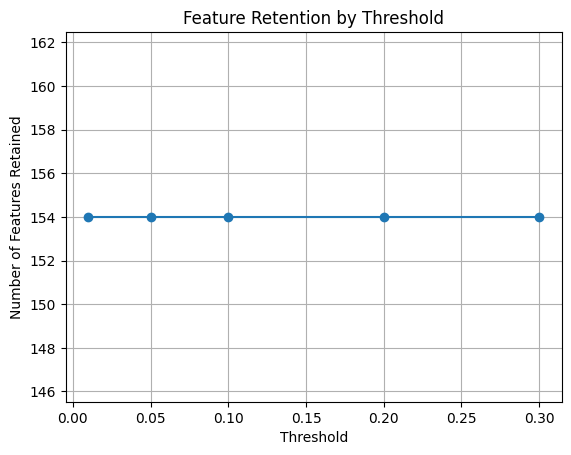

In [281]:
# if your variation scores range, you can also check out which treshold might work better 
# however, it is not a case here

from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

# Test different thresholds to see how many features are retained at each level
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3]  # List of thresholds to evaluate
features_retained = []  # Store the number of features retained for each threshold

for t in thresholds:
    # Apply VarianceThreshold for each threshold to filter low-variance features
    vth = VarianceThreshold(threshold=t)  
    vth.fit(X_train_std)  # Fit to the standardized training data
    features_retained.append(sum(vth.get_support()))  # Count retained features and store

# Plot retained features against thresholds to visualize the impact of threshold selection
plt.plot(thresholds, features_retained, marker='o')  
plt.xlabel('Threshold')  # X-axis shows variance threshold levels
plt.ylabel('Number of Features Retained')  # Y-axis shows features retained at each threshold
plt.title('Feature Retention by Threshold')  
plt.grid(True)  # Add grid for better readability
plt.show()  



## Cross validation 

Number of features selected in at least one fold: 154
Selected Features:
['U031D1' 'U031D6St' 'U031D3id_1' 'U031D3id_2' 'U031D3id_3' 'U031D3id_4'
 'U031D3id_5' 'U031D3id_6' 'U031D3id_7' 'U031SV5R' 'U031SV6R' 'U031SV8R'
 'U031SV9R' 'U031SV10R' 'U031SV12R' 'U031SV13R' 'U031SV19R' 'U031SV20R'
 'U031SV21R' 'U031SV22R' 'U031SV23R2' 'U031SV24R' 'U031SV26'
 'U031BU1R_0_1' 'U031BU3R_0_4' 'U031BU4R_0_4' 'U031BU5R_0_1' 'U031BU13R'
 'U031BU19' 'U031CB2R_binary' 'U031SE1R' 'U031SE2R' 'U031SE4R' 'U031SE5R'
 'U031SE6R' 'U031SE7R' 'U031SE8R' 'U031AE1R' 'U031AE2R' 'U031AE3R'
 'U031AE4R' 'U031AE5R' 'U031AE6R' 'U031AE7' 'U031MR1R' 'U031MR2R'
 'U031MR3R' 'U031FI1R' 'U031FI2R' 'U031FI3R' 'U031FI4R' 'U031FI5R'
 'U031EI5R' 'U031EI6R' 'U031EI7R' 'U031EI8R' 'U031EI1R' 'U031EI2R'
 'U031EI3R' 'U031EI4R' 'U031EI9R' 'U031EI10R' 'U031EI11R' 'U031EI12R'
 'U031EI13R' 'U031CO1R' 'U031CO2R' 'U031CO3R' 'U031CO4R' 'U031CO5R'
 'U031CO6R' 'U031CO7R' 'U031CO8R' 'U031CO9R' 'U031CO10R' 'U031CO11R'
 'U031CO12R' 'U031CO13R' 'U

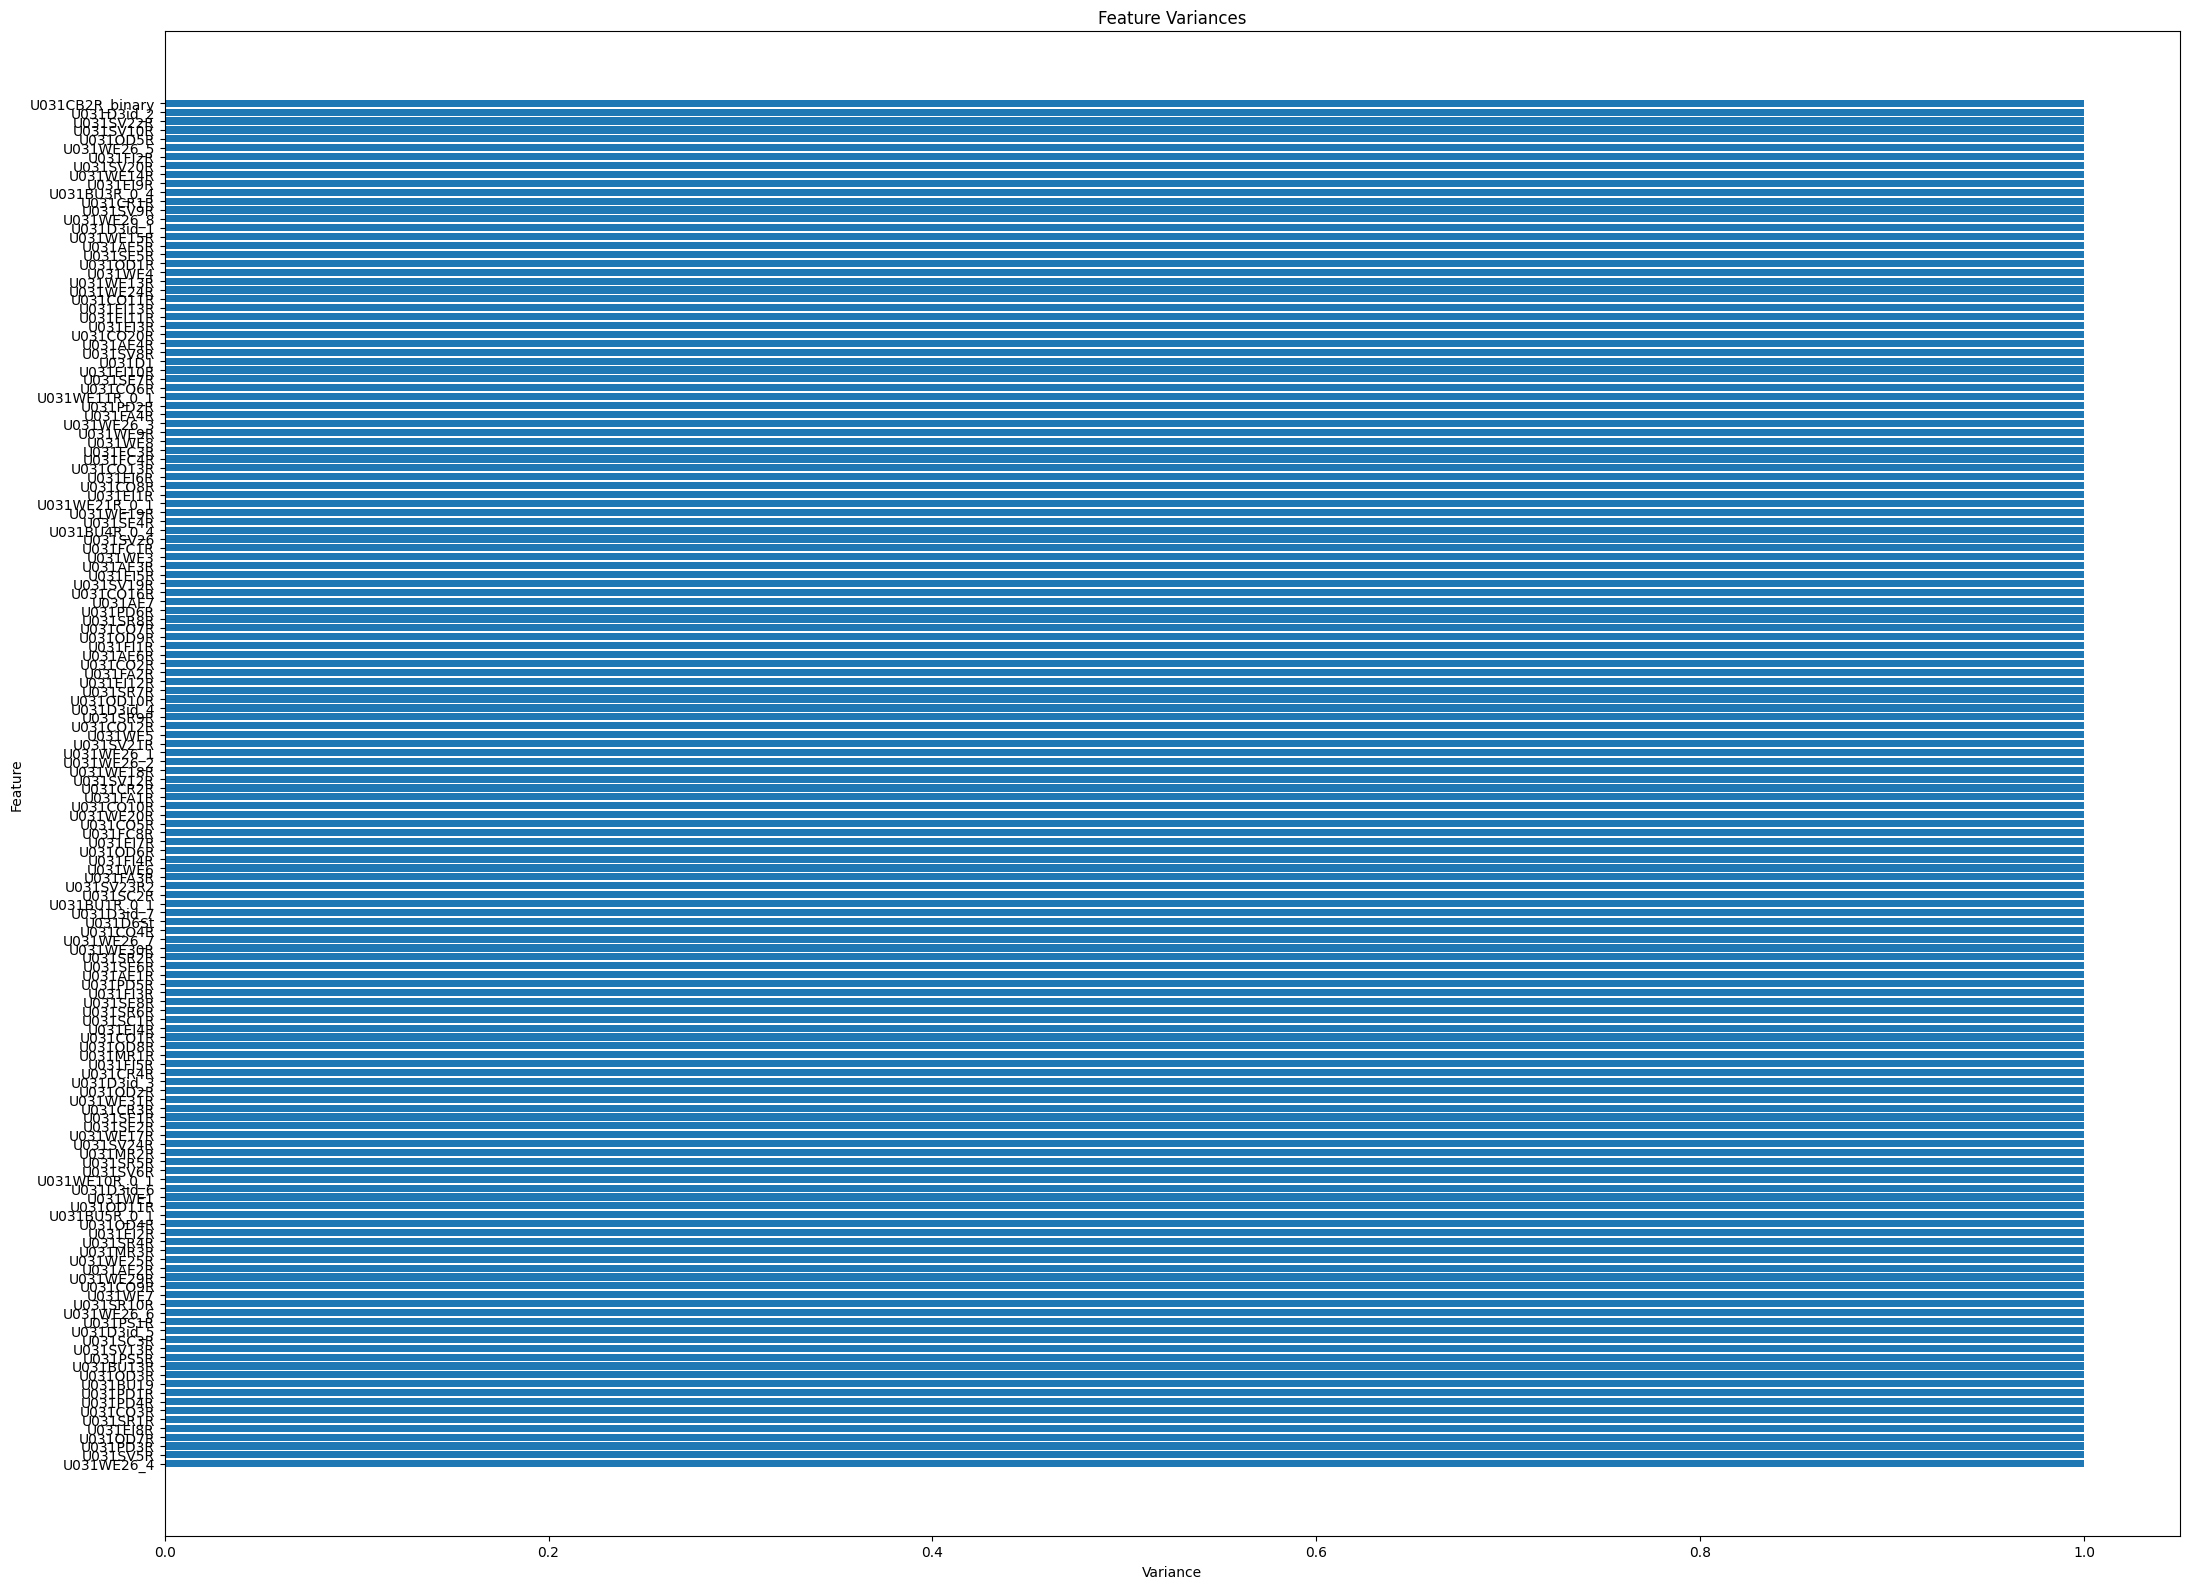

             Feature  Variance
141       U031WE26_4       1.0
9           U031SV5R       1.0
108         U031PD3R       1.0
86          U031OD7R       1.0
55          U031EI8R       1.0
..               ...       ...
84          U031OD5R       1.0
13         U031SV10R       1.0
19         U031SV22R       1.0
3         U031D3id_2       1.0
29   U031CB2R_binary       1.0

[154 rows x 2 columns]


In [282]:
# now we are changing threshold level based on above experiment
# since treshold level does not work as expected, then I get 75 percentile

# introduce 10 fold cross validation

from sklearn.model_selection import StratifiedKFold  # For stratified cross-validation


# Initialize Stratified 10-Fold Cross-Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Placeholder to track selected features across folds
selected_features = np.zeros(X_train_std.shape[1])

# Cross-validation loop
for train_index, test_index in kf.split(X_train_std, y_train):
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_std[train_index], X_train_std[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
    
    # Dynamically set threshold based on the 5th percentile of variances in the fold
    #threshold = np.percentile(X_train_fold.var(axis=0), 5)  # Calculate 5th percentile variance
    
    # after some experiment, I increase the percentile to limit the variables
    threshold = np.percentile(X_train_std.var(axis=0), 75)  # Increase to 75th percentile
    

    vth = VarianceThreshold(threshold=threshold)  # Initialize VarianceThreshold
    
    # Fit the variance threshold model on the training fold
    vth.fit(X_train_fold)
    
    # Track selected features using 'get_support()'
    selected_features += vth.get_support()  # Add up selections across folds

# Final feature selection summary
selected_features_mask = selected_features > 0  # Features selected at least once
print(f"Number of features selected in at least one fold: {sum(selected_features_mask)}")

# Retrieve original feature names
d1 = data.columns[1:]  # Exclude target variable
selected_feature_names = np.array(d1)[selected_features_mask]  # Filter selected features

# Display selected features
print("Selected Features:")
print(selected_feature_names)

# Visualize variance distribution for all features
feature_variances = pd.DataFrame({
    'Feature': d1,
    'Variance': X_train_std.var(axis=0)
})

# Sort by variance for better readability
feature_variances = feature_variances.sort_values('Variance', ascending=True)



# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(22, 16))
plt.barh(feature_variances['Feature'], feature_variances['Variance'])
plt.xlabel('Variance')
plt.ylabel('Feature')
plt.title('Feature Variances')
plt.tight_layout()
plt.show()


# Display feature variances
print(feature_variances)

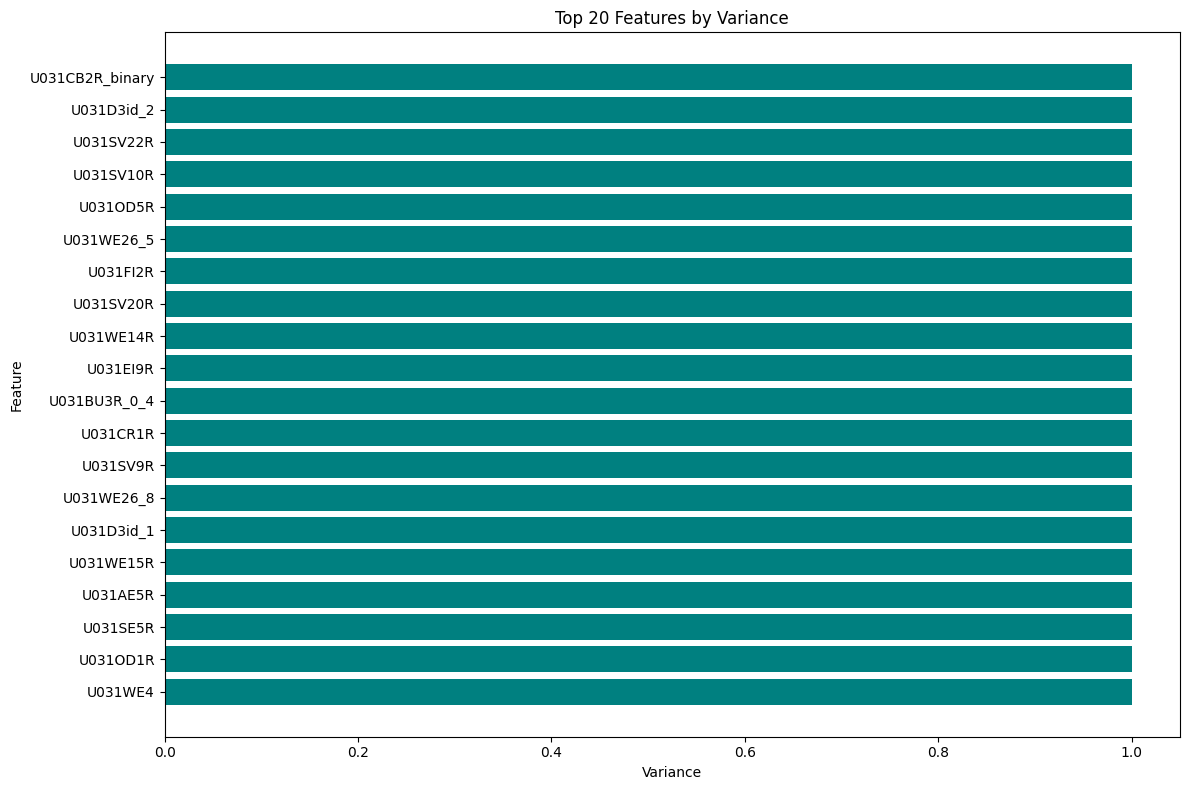

             Feature  Variance
29   U031CB2R_binary       1.0
3         U031D3id_2       1.0
19         U031SV22R       1.0
13         U031SV10R       1.0
84          U031OD5R       1.0
142       U031WE26_5       1.0
48          U031FI2R       1.0
17         U031SV20R       1.0
150        U031WE14R       1.0
60          U031EI9R       1.0
24      U031BU3R_0_4       1.0
112         U031CR1R       1.0
12          U031SV9R       1.0
145       U031WE26_8       1.0
2         U031D3id_1       1.0
151        U031WE15R       1.0
41          U031AE5R       1.0
33          U031SE5R       1.0
80          U031OD1R       1.0
121          U031WE4       1.0


In [283]:
# Let's examine the top 20 features.
# Note: Since only a few variables have variance lower than 1.0, 
# this approach is currently hypothetical. 
# Use this method meaningfully if your dataset contains features with genuinely low variance.


# Sort features by variance in descending order
sorted_variances = feature_variances.sort_values('Variance', ascending=False)

# Select the top 20 features based on variance
top_20_features = sorted_variances.head(20)



# Visualization for top 20 features
plt.figure(figsize=(12, 8))  # Adjust figure size for better readability
plt.barh(top_20_features['Feature'], top_20_features['Variance'], color='teal')  # Horizontal bar chart
plt.xlabel('Variance')  # X-axis label
plt.ylabel('Feature')  # Y-axis label
plt.title('Top 20 Features by Variance')  # Title
plt.gca().invert_yaxis()  # Invert y-axis to display highest variance at the top
plt.tight_layout()
plt.show()


# Display the top 20 features
print(top_20_features)

In [284]:
# Count features below the threshold
# we used final treshold level to see how it will affect out choice

threshold = np.percentile(X_train_std.var(axis=0), 75) 

low_variance_count = sum(vth.variances_ < threshold)

print(f"Number of features with variance below {threshold}: {low_variance_count}")

# with this model, we can only eliminate more variables efficiently since most almost all variables have around 10.0  variance
# With percentile choice, we could delete 119 bariable but these results are too weak to rely on 


Number of features with variance below 1.0000000000000246: 119


In [285]:
# Display the features with variance below the threshold
low_variance_features = pd.DataFrame(
    {'Feature': d1, 'Variance': vth.variances_}
)

low_variance_features = low_variance_features[low_variance_features['Variance'] < threshold]

print(low_variance_features)


        Feature  Variance
0        U031D1  0.999849
2    U031D3id_1  0.997216
3    U031D3id_2  0.999981
5    U031D3id_4  0.977333
6    U031D3id_5  0.994851
..          ...       ...
149   U031WE13R  0.997663
150   U031WE14R  0.986972
151   U031WE15R  0.991986
152   U031WE19R  0.993066
153   U031WE20R  0.985290

[119 rows x 2 columns]


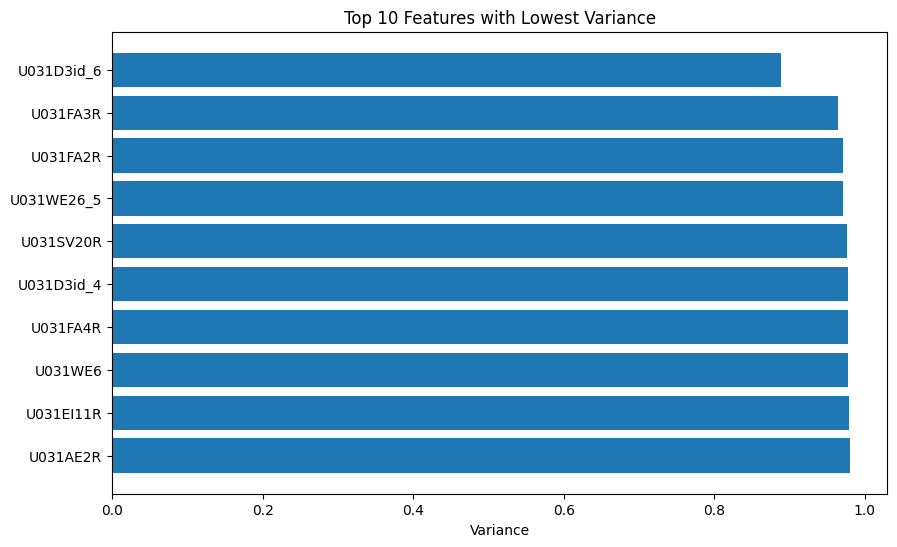

In [286]:
# Plot top 10 features
# in this case, it does not work as expected because we have too many variable that have 1.0 variance
# however, in different data set, you can get different results

# Create a DataFrame to hold the features and their variances
variance_df = pd.DataFrame({'Feature': d1, 'Variance': vth.variances_})

# Sort the DataFrame by variance in ascending order and get the top 10 features
top_10_features = variance_df.sort_values(by='Variance', ascending=True).head(10)

# Create a bar plot to visualize the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Variance'])
plt.xlabel('Variance')
plt.title('Top 10 Features with Lowest Variance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest variance at the top
plt.show()


##  Select KBest for Classification Problems

SelectKBest is a feature selection method that selects the k best features based on statistical tests. It is commonly used in classification problems to identify features with the strongest relationship to the target variable.

Many different statistical tests can be used with this method. For example, the ANOVA F-value test is suitable for numerical inputs and categorical outputs, as seen in the Pima dataset. This can be implemented using the f_classif() function.



**Key Parameters of SelectKBest:**

    score_func: The statistical test (filter function) used for feature selection.
        Example: f_classif() for classification problems with numerical inputs and categorical outputs.
    k: The number of top features to select.
        Example: k=10 selects the 10 most important features.

Feature 0: selected in 0 out of 10 folds
Feature 1: selected in 10 out of 10 folds
Feature 2: selected in 0 out of 10 folds
Feature 3: selected in 0 out of 10 folds
Feature 4: selected in 0 out of 10 folds
Feature 5: selected in 0 out of 10 folds
Feature 6: selected in 0 out of 10 folds
Feature 7: selected in 0 out of 10 folds
Feature 8: selected in 0 out of 10 folds
Feature 9: selected in 0 out of 10 folds
Feature 10: selected in 0 out of 10 folds
Feature 11: selected in 0 out of 10 folds
Feature 12: selected in 0 out of 10 folds
Feature 13: selected in 0 out of 10 folds
Feature 14: selected in 0 out of 10 folds
Feature 15: selected in 0 out of 10 folds
Feature 16: selected in 10 out of 10 folds
Feature 17: selected in 10 out of 10 folds
Feature 18: selected in 0 out of 10 folds
Feature 19: selected in 9 out of 10 folds
Feature 20: selected in 10 out of 10 folds
Feature 21: selected in 10 out of 10 folds
Feature 22: selected in 0 out of 10 folds
Feature 23: selected in 0 out of 10 fol

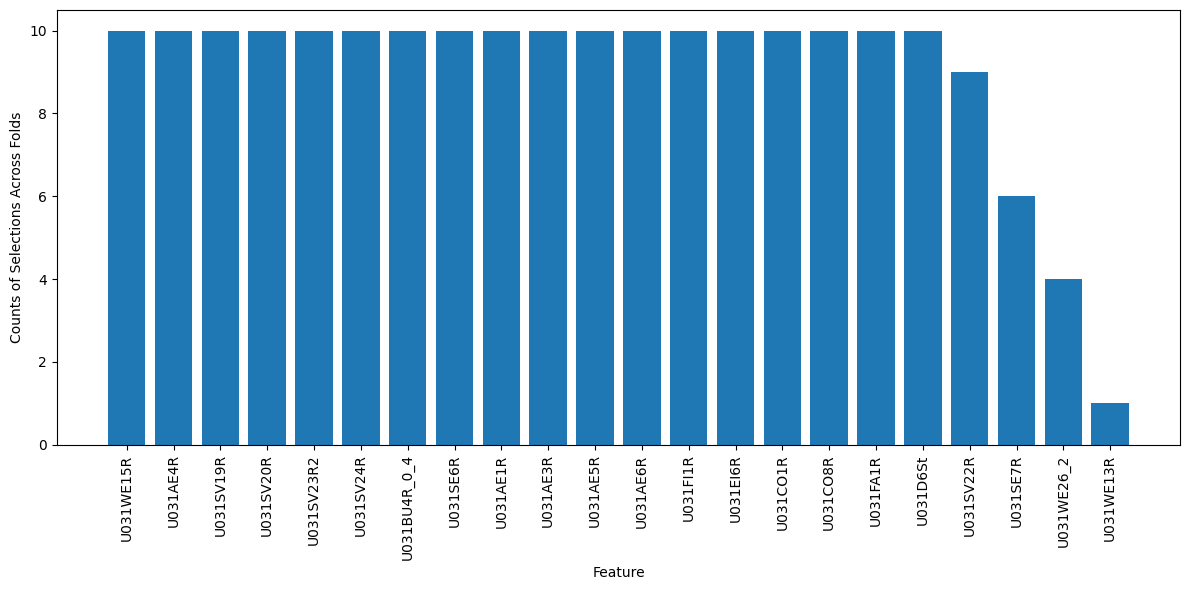

['U031WE15R' 'U031AE4R' 'U031SV19R' 'U031SV20R' 'U031SV23R2' 'U031SV24R'
 'U031BU4R_0_4' 'U031SE6R' 'U031AE1R' 'U031AE3R' 'U031AE5R' 'U031AE6R'
 'U031FI1R' 'U031EI6R' 'U031CO1R' 'U031CO8R' 'U031FA1R' 'U031D6St'
 'U031SV22R' 'U031SE7R' 'U031WE26_2' 'U031WE13R']


In [287]:
# Import necessary libraries
from sklearn.model_selection import StratifiedKFold  # For stratified cross-validation
from sklearn.feature_selection import SelectKBest, f_classif  # For feature selection

# Setup StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# n_splits=10: Splits data into 10 folds
# shuffle=True: Shuffles the data before splitting to ensure randomness
# random_state=42: Ensures reproducibility of results

# Initialize an array to track feature selection across all folds
feature_selections = np.zeros((X_train_std.shape[1], kf.n_splits), dtype=bool)
# Rows represent features, and columns represent folds

# Cross-validation loop
fold = 0  # Initialize fold counter
for train_index, test_index in kf.split(X_train_std, y_train):  # Split data into train and test for each fold
    # Extract training and testing data for the current fold
    X_train_fold, X_test_fold = X_train_std[train_index], X_train_std[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    # Feature selection using ANOVA F-test
    selector = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features
    # score_func=f_classif: Uses ANOVA F-value to score features for classification
    X_train_fold_selected = selector.fit_transform(X_train_fold, y_train_fold)  # Fit and transform training data
    
    # Track which features were selected in this fold
    feature_selections[:, fold] = selector.get_support()  # 'get_support()' returns a mask of selected features
    fold += 1  # Move to the next fold

# Count how many times each feature was selected across folds
feature_selected_counts = np.sum(feature_selections, axis=1)

# Print the selection frequency for each feature
for i, count in enumerate(feature_selected_counts):
    print(f'Feature {i}: selected in {count} out of {kf.n_splits} folds')

# Retrieve feature names from the dataset
feature_names = data.columns[1:].tolist()  # Exclude the target variable column (cannabis)

# Select features that were chosen at least once across folds
selected_features_mask = feature_selected_counts > 0  # Mask for features selected at least once
selected_feature_names = np.array(feature_names)[selected_features_mask]  # Get names of selected features
selected_feature_counts = feature_selected_counts[selected_features_mask]  # Count of selections for each feature

# Sort the selected features by their selection frequency in descending order
sorted_indices = np.argsort(selected_feature_counts)[::-1]  # Get indices sorted by frequency (descending)
sorted_feature_names = selected_feature_names[sorted_indices]  # Sort feature names based on frequency
sorted_feature_counts = selected_feature_counts[sorted_indices]  # Sort counts based on frequency

# Plot the selection frequency of the features
plt.figure(figsize=(12, 6))  # Set figure size for better visualization
plt.bar(sorted_feature_names, sorted_feature_counts)  # Create bar plot
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel('Feature')  # Label x-axis
plt.ylabel('Counts of Selections Across Folds')  # Label y-axis
plt.tight_layout()  # Ensure labels fit properly in the figure
plt.show()

# Print the sorted selected feature names
print(sorted_feature_names)


### Cross validation + Class weights


The initial K-Best algorithm applied feature selection without considering class imbalance in the dataset. This could lead to biased results, favoring the majority class and overlooking patterns in the minority class. To address this issue, we incorporated class weights into the classifier to improve performance in imbalanced classification tasks.

How We Changed It:

- Pipeline Integration: We combined feature selection (SelectKBest) and classification (RandomForestClassifier) into a single pipeline. This ensures consistent preprocessing during training and testing.
- Class Weights Adjustment: We added class_weight='balanced' to the classifier, which automatically adjusts weights based on class frequencies, making it more robust for imbalanced datasets.
- Cross-Validation Tracking: Instead of relying on a single run, we used StratifiedKFold cross-validation to track feature selection stability across folds. This approach identifies features that consistently contribute to model performance.

Do result change a lot? Not much but we are not at least ensure handling the data imbalance

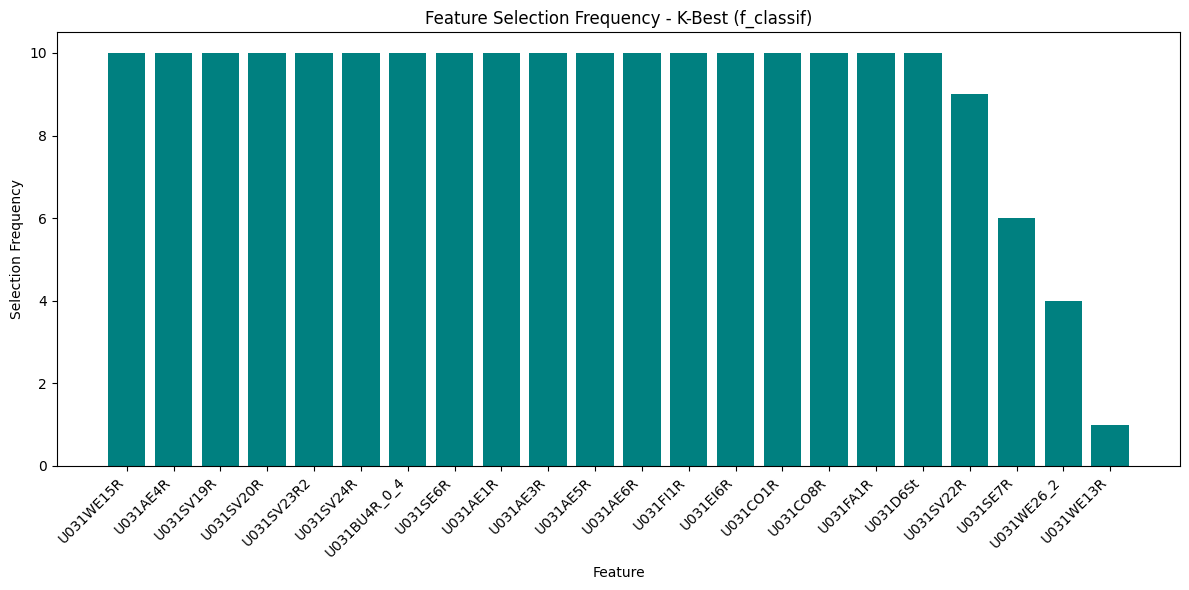

['U031WE15R' 'U031AE4R' 'U031SV19R' 'U031SV20R' 'U031SV23R2' 'U031SV24R'
 'U031BU4R_0_4' 'U031SE6R' 'U031AE1R' 'U031AE3R' 'U031AE5R' 'U031AE6R'
 'U031FI1R' 'U031EI6R' 'U031CO1R' 'U031CO8R' 'U031FA1R' 'U031D6St'
 'U031SV22R' 'U031SE7R' 'U031WE26_2' 'U031WE13R']


In [288]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import matplotlib.pyplot as plt

# Placeholder to count how often each feature is selected across folds
selected_features = np.zeros(X_train_std.shape[1])

# Cross-validation loop
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_train_std, y_train):
    # Split data
    X_train_fold, y_train_fold = X_train_std[train_index], y_train[train_index]
    
    # Feature selection using K-Best
    selector = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features
    selector.fit(X_train_fold, y_train_fold)
    
    # Track selected features
    selected_features += selector.get_support()

import matplotlib.pyplot as plt
import numpy as np

# Sort features based on selection frequency
sorted_indices = np.argsort(selected_features[selected_features_mask])[::-1]  # Descending order
sorted_features = selected_feature_names[sorted_indices]  # Sorted feature names
sorted_counts = selected_features[selected_features_mask][sorted_indices]  # Sorted counts

# Plot the sorted features
plt.figure(figsize=(12, 6))  # Adjust figure size
plt.bar(sorted_features, sorted_counts, color='teal')  # Bar chart with sorted values
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.xlabel('Feature')  # Label x-axis
plt.ylabel('Selection Frequency')  # Label y-axis
plt.title('Feature Selection Frequency - K-Best (f_classif)')  # Add title
plt.tight_layout()  # Prevent label overlap
plt.show()

# Display the sorted feature names
print(sorted_feature_names)


##  Information Gain - Classification Problems


Mutual information (MI) measures the dependence of one variable to another by quantifying the amount of information obtained about one feature, through the other feature. MI is symmetric and non-negative, and is zero if and only if the input and output feature are independent. Unlike ANOVA F-value, mutual information can capture non-linear relationships between input and output feature.

We can use Scikit-learn to calculate MI. Scikit-learn has two functions to calculate MI:

    - mutual_info_classif, which calculate MI for classification task
    - mutual_info_regression, which calculate MI for regression task


Feature 0 : 0.003
Feature 1 : 0.044
Feature 2 : 0.001
Feature 3 : 0.005
Feature 4 : 0.002
Feature 5 : 0.004
Feature 6 : 0.001
Feature 7 : 0.002
Feature 8 : 0.002
Feature 9 : 0.007
Feature 10 : 0.006
Feature 11 : 0.016
Feature 12 : 0.002
Feature 13 : 0.007
Feature 14 : 0.002
Feature 15 : 0.005
Feature 16 : 0.029
Feature 17 : 0.019
Feature 18 : 0.011
Feature 19 : 0.021
Feature 20 : 0.044
Feature 21 : 0.029
Feature 22 : 0.013
Feature 23 : 0.002
Feature 24 : 0.008
Feature 25 : 0.018
Feature 26 : 0.002
Feature 27 : 0.015
Feature 28 : 0.006
Feature 29 : 0.001
Feature 30 : 0.016
Feature 31 : 0.015
Feature 32 : 0.018
Feature 33 : 0.015
Feature 34 : 0.027
Feature 35 : 0.02
Feature 36 : 0.006
Feature 37 : 0.028
Feature 38 : 0.012
Feature 39 : 0.022
Feature 40 : 0.027
Feature 41 : 0.016
Feature 42 : 0.025
Feature 43 : 0.007
Feature 44 : 0.013
Feature 45 : 0.004
Feature 46 : 0.01
Feature 47 : 0.02
Feature 48 : 0.014
Feature 49 : 0.013
Feature 50 : 0.009
Feature 51 : 0.003
Feature 52 : 0.017
Featur

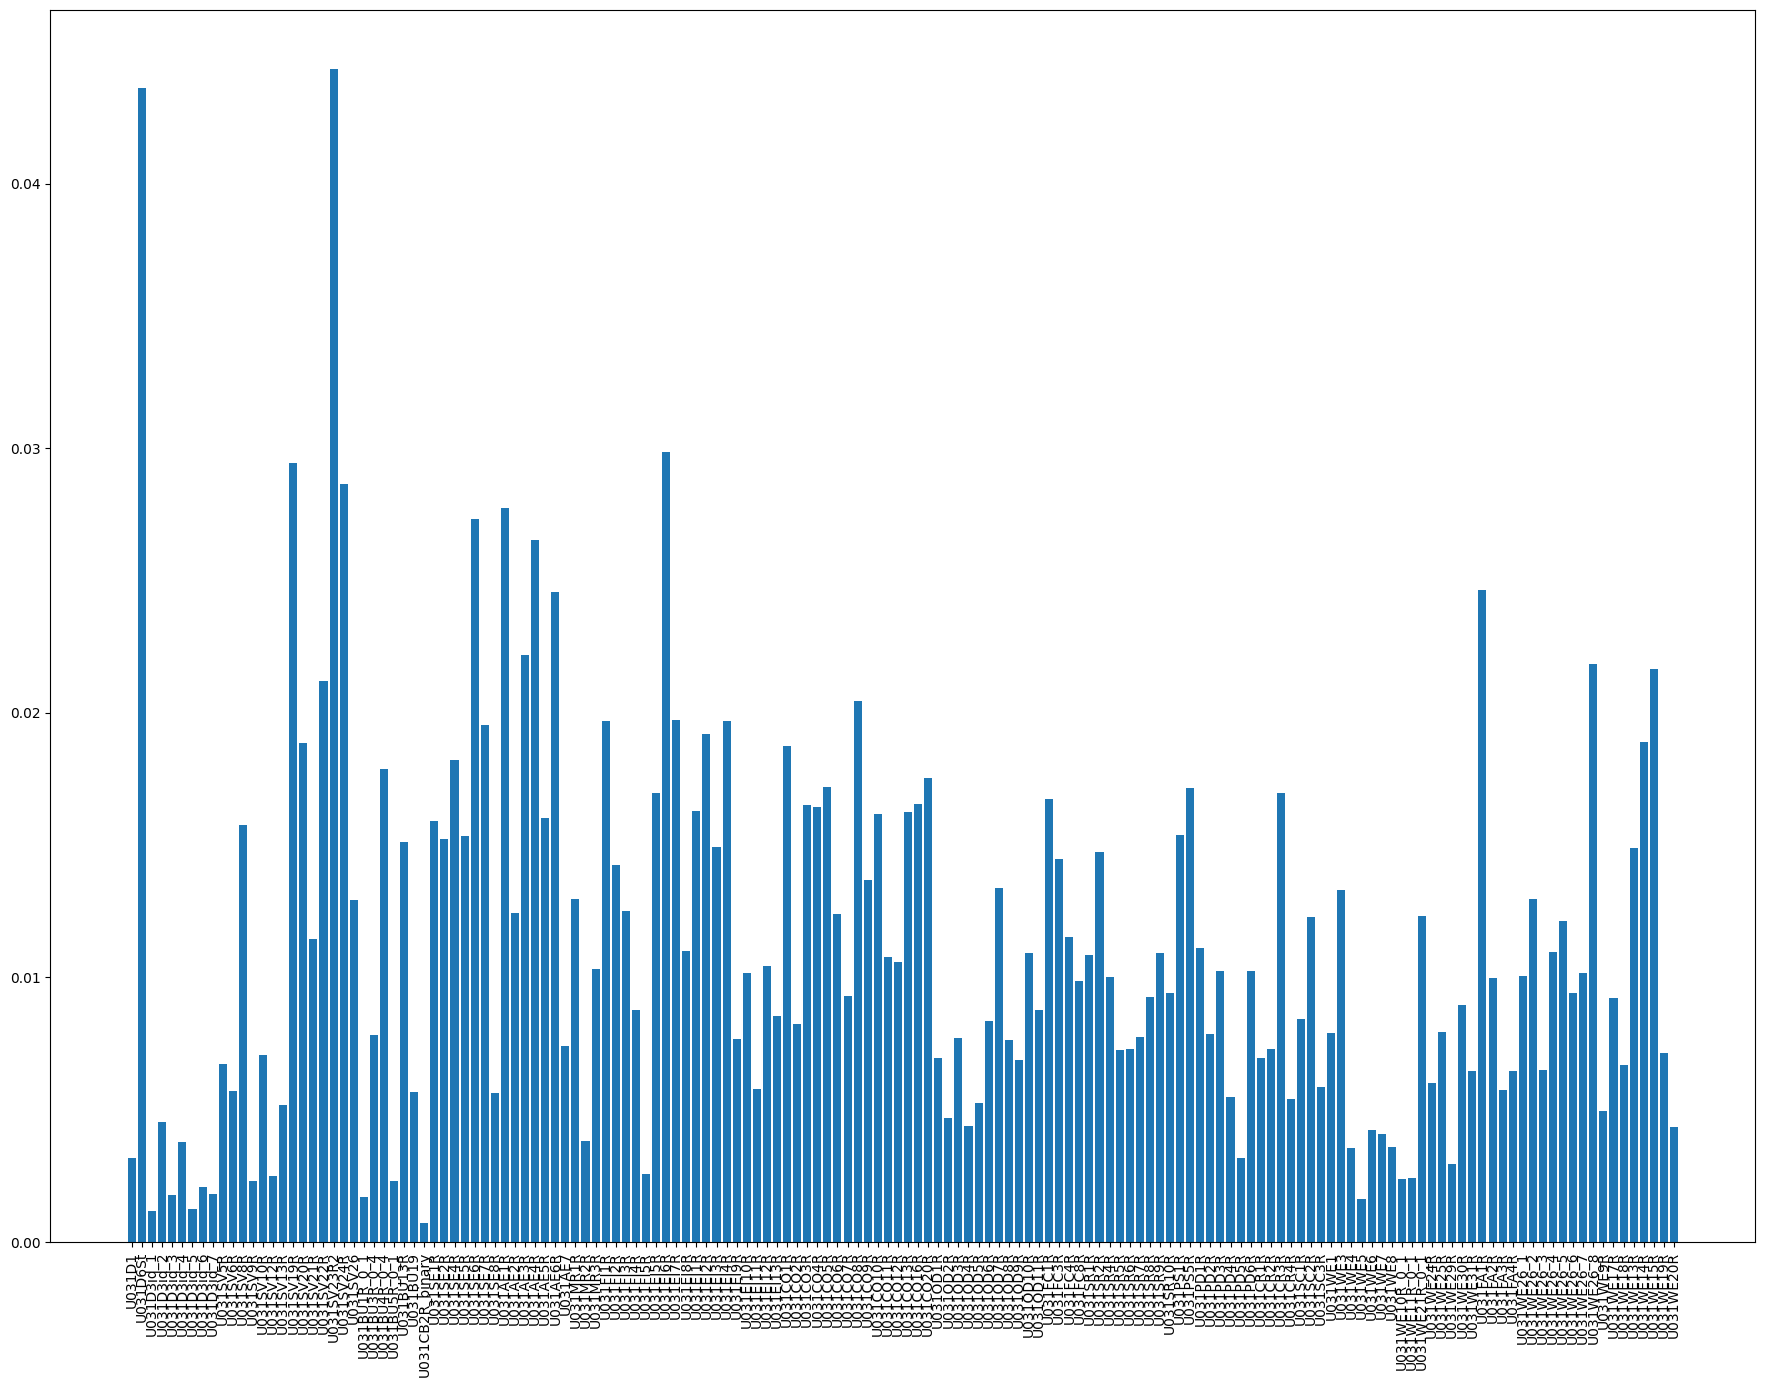

In [289]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

# Setup StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Placeholder for feature scores
feature_scores = np.zeros(X_train_std.shape[1])

# Perform feature selection within each fold of the cross-validation
for train_index, test_index in kf.split(X_train_std, y_train):
    X_train_fold, y_train_fold = X_train_std[train_index], y_train[train_index]

    # Feature selection
    infogain_classif = SelectKBest(score_func=mutual_info_classif, k=20)
    infogain_classif.fit(X_train_fold, y_train_fold)
    
    # Collect the scores
    feature_scores += infogain_classif.scores_

# Average the scores over all folds
feature_scores /= kf.n_splits

# Print the averaged feature scores
for i, score in enumerate(feature_scores):
    print(f'Feature {i} : {round(score, 3)}')

print()

# Assuming 'd1' is a list of feature names in the correct order
plt.figure(figsize=(22, 16))
plt.bar([d1[i] for i in range(len(feature_scores))], feature_scores)
plt.xticks(rotation=90)
plt.show()


Feature U031SV23R2 : 0.044
Feature U031D6St : 0.044
Feature U031EI6R : 0.03
Feature U031SV19R : 0.029
Feature U031SV24R : 0.029
Feature U031AE1R : 0.028
Feature U031SE6R : 0.027
Feature U031AE4R : 0.027
Feature U031FA1R : 0.025
Feature U031AE6R : 0.025
Feature U031AE3R : 0.022
Feature U031WE26_8 : 0.022
Feature U031WE15R : 0.022
Feature U031SV22R : 0.021
Feature U031CO8R : 0.02
Feature U031EI7R : 0.02
Feature U031EI4R : 0.02
Feature U031FI1R : 0.02
Feature U031SE7R : 0.02
Feature U031EI2R : 0.019



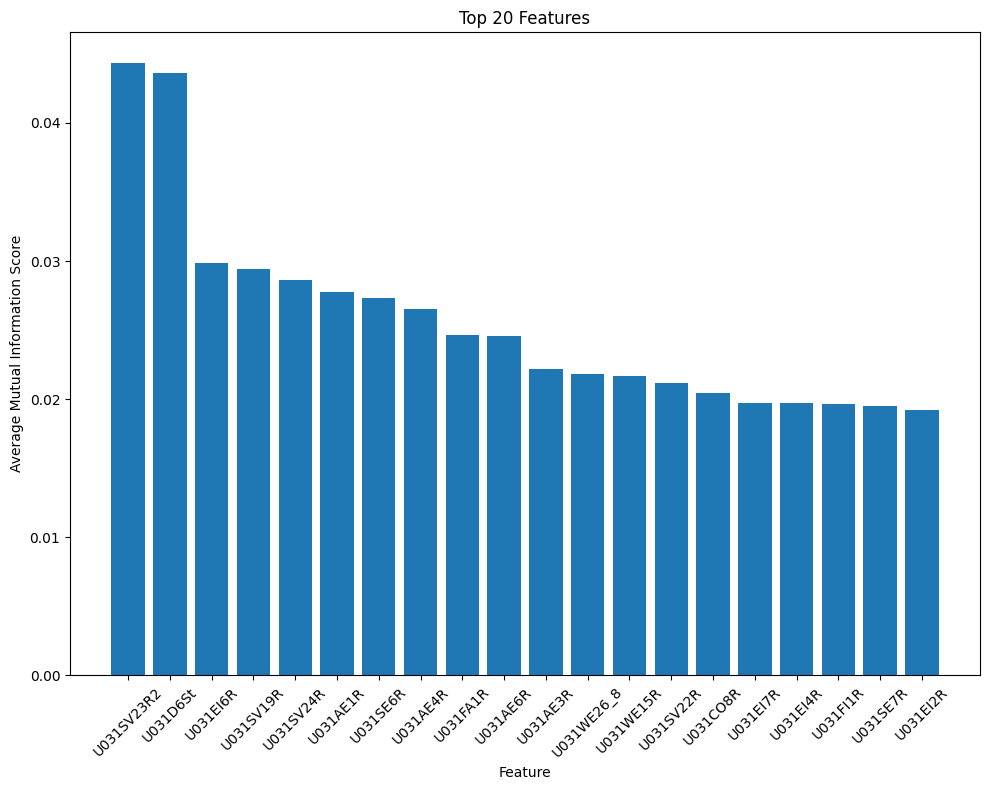

['U031SV23R2' 'U031D6St' 'U031EI6R' 'U031SV19R' 'U031SV24R' 'U031AE1R'
 'U031SE6R' 'U031AE4R' 'U031FA1R' 'U031AE6R' 'U031AE3R' 'U031WE26_8'
 'U031WE15R' 'U031SV22R' 'U031CO8R' 'U031EI7R' 'U031EI4R' 'U031FI1R'
 'U031SE7R' 'U031EI2R']


In [290]:
# now we are focusing on top 20 features

# Sort features by score
sorted_indices = np.argsort(feature_scores)[::-1]
sorted_scores = feature_scores[sorted_indices]

# Select the top 10 features
top_k_indices = sorted_indices[:20]
top_k_scores = sorted_scores[:20]

# Get the feature names
# Replace 'd1' with the actual list of feature names corresponding to your dataset
feature_names = np.array(d1)[top_k_indices]

# Print the top 10 feature scores
for i, index in enumerate(top_k_indices):
    print(f'Feature {feature_names[i]} : {round(top_k_scores[i], 3)}')

print()

# Plot the scores of the top 10 features
plt.figure(figsize=(10, 8))
plt.bar(feature_names, top_k_scores)
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Average Mutual Information Score')
plt.title('Top 20 Features')
plt.tight_layout()
plt.show()

print(feature_names)

### Cross validation 

Mutual Information is a filter method that evaluates dependency between features and the target variable before modeling and does not depend on a classifier. So, we do not need a classifier for class balancing

Top 20 Features Based on Mutual Information:
U031SV23R2: 0.044
U031D6St: 0.042
U031EI6R: 0.031
U031SV19R: 0.03
U031SE6R: 0.028
U031SV24R: 0.027
U031AE4R: 0.026
U031AE1R: 0.025
U031AE3R: 0.025
U031FI1R: 0.024
U031AE6R: 0.022
U031BU4R_0_4: 0.022
U031SV22R: 0.021
U031CO13R: 0.021
U031FA1R: 0.021
U031FC1R: 0.021
U031WE15R: 0.019
U031SE7R: 0.019
U031CO8R: 0.019
U031EI7R: 0.019


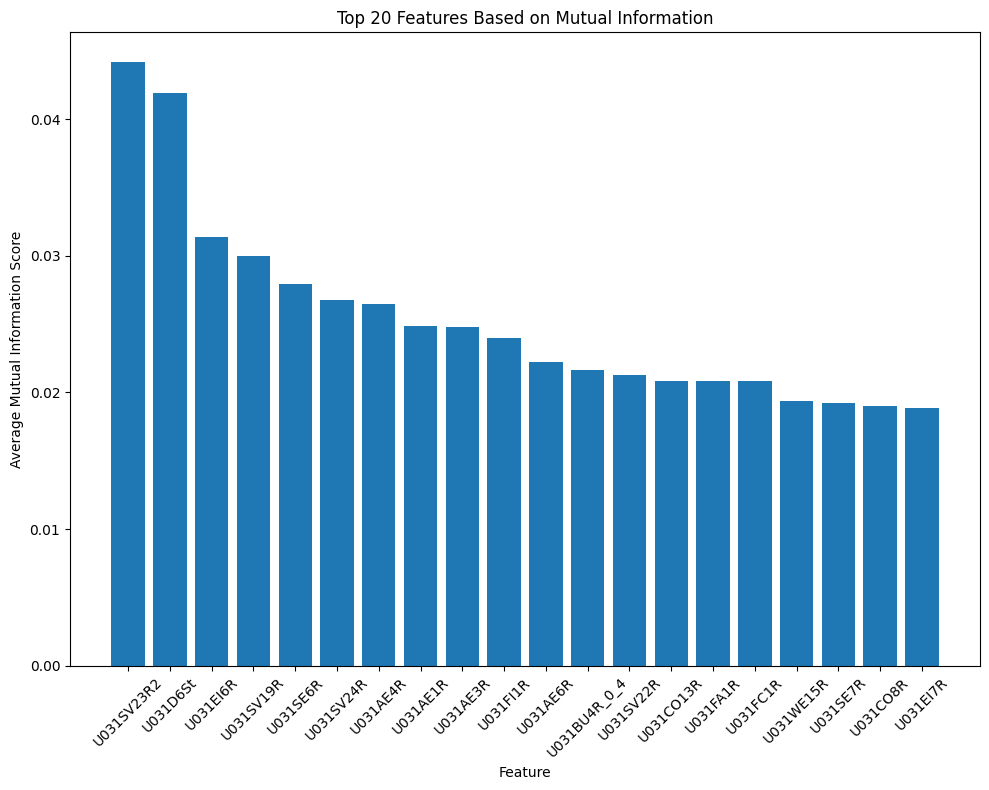

In [291]:
# Import necessary libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import numpy as np
import matplotlib.pyplot as plt

# Setup StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Placeholder for feature scores
feature_scores = np.zeros(X_train_std.shape[1])

# Cross-validation loop
for train_index, test_index in kf.split(X_train_std, y_train):
    # Split data into folds
    X_train_fold, y_train_fold = X_train_std[train_index], y_train[train_index]
    
    # Feature selection using Mutual Information (Information Gain)
    infogain_classif = SelectKBest(score_func=mutual_info_classif, k='all')  # Evaluate all features
    infogain_classif.fit(X_train_fold, y_train_fold)  # Fit to calculate scores

    # Collect scores across folds
    feature_scores += infogain_classif.scores_

# Average scores over all folds
feature_scores /= kf.n_splits

# Sort features by scores in descending order
sorted_indices = np.argsort(feature_scores)[::-1]  # Sort indices by score
top_k_indices = sorted_indices[:20]  # Select top 20 features

# Get top feature scores and names
sorted_scores = feature_scores[top_k_indices]
top_feature_names = np.array(d1)[top_k_indices]  # Assuming 'd1' contains feature names

# Print top 20 features
print('Top 20 Features Based on Mutual Information:')
for i, feature in enumerate(top_feature_names):
    print(f'{feature}: {round(sorted_scores[i], 3)}')

# Plot the top 20 features
plt.figure(figsize=(10, 8))
plt.bar(top_feature_names, sorted_scores)
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Average Mutual Information Score')
plt.title('Top 20 Features Based on Mutual Information')
plt.tight_layout()
plt.show()


In [292]:
# I used this list for copy-past purpose for the next stages
print(top_feature_names)

['U031SV23R2' 'U031D6St' 'U031EI6R' 'U031SV19R' 'U031SE6R' 'U031SV24R'
 'U031AE4R' 'U031AE1R' 'U031AE3R' 'U031FI1R' 'U031AE6R' 'U031BU4R_0_4'
 'U031SV22R' 'U031CO13R' 'U031FA1R' 'U031FC1R' 'U031WE15R' 'U031SE7R'
 'U031CO8R' 'U031EI7R']


# Embedded Models

Embedded methods combine the strong points of filter and wrapper methods by taking advantage of machine algorithms that have their own built-in feature selection process. They integrate a feature selection step as a part of the training process (i.e., feature selection and training process are performed simultaneously). Embedded methods generally have a more efficient process than wrapper methods because they eliminate the need to retrain every single subset of features being examined. Some of machine algorithms that can be used for feature selection are:

- LASSO regression
- Decision tree
-  Random forest
- Support vector machine


If your data has class imbalance, you need to address it when using model-based methods (e.g., Random Forest or Logistic Regression) during training and evaluation, not during feature selection with filter methods.

## Feature Selection with L1 Regularization

**L1 regularization**, also known as **Lasso (Least Absolute Shrinkage and Selection Operator)**, is a type of **embedded method** for **feature selection** that integrates feature importance evaluation directly into the training process of a machine learning model. It applies a **penalty** to the absolute values of coefficients, forcing some of them to become **zero**, effectively removing less important features from the model.  

In this approach, **Logistic Regression** with L1 regularization is used to simultaneously **train the model** and **select features**, making it an efficient and interpretable method for high-dimensional datasets.  

**Key Advantages of L1 Regularization for Feature Selection:**  
- **Sparse Solutions:** Reduces the number of non-zero coefficients, resulting in automatic feature selection and simplified models.  
- **Embedded Feature Selection:** Performs feature selection as part of model training, avoiding separate preprocessing steps.  
- **Handles High Dimensionality:** Effective for datasets with a large number of features, where traditional filtering methods may struggle.  
- **Regularization Strength Control (C):** Allows flexibility in controlling the degree of feature selection by adjusting the inverse of the regularization strength parameter (**C**).  

**Applications:**  
- **Dimensionality Reduction:** Automatically eliminates irrelevant or redundant features, improving model interpretability and efficiency.  
- **Visualization of Feature Weights:** Tracks changes in feature importance based on regularization strength, providing insights into feature stability and relevance.  

The following implementation demonstrates how **L1 regularization** is applied to **Logistic Regression** for feature selection. It visualizes how feature weights change as the regularization strength (**C**) is adjusted, helping identify important features based on their stability across different values of **C**.


In [293]:
from sklearn.linear_model import LogisticRegression

LogisticRegression(penalty='l1')

LogisticRegression(penalty='l1')

In [294]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0, 
                        solver='liblinear',
                        multi_class='ovr',
                        class_weight='balanced',
                        random_state=0)
# Note that C=1.0 is the default. You can increase
# or decrease it to make the regulariztion effect
# stronger or weaker, respectively.

lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.826
Test accuracy: 0.798


In [295]:
lr.intercept_

array([-1.27506842])

Since we have only one class in target, it gives us only one value, which can also interpreted as coeffient. 

In [296]:
np.set_printoptions(8)


In [297]:
# number of features with defaul penalty treshold
lr.coef_[lr.coef_!=0].shape



(148,)

In [298]:
lr.coef_

array([[ 5.24101321e-02,  8.74853769e-01,  6.38145767e-02,
         3.30450026e-01,  1.00603136e-01, -1.23179945e-01,
         2.07955247e-01, -2.00007485e-02,  0.00000000e+00,
         1.09446578e-01,  2.15145730e-01, -4.07763611e-02,
        -1.41376669e-01, -7.98264768e-02,  2.13920854e-02,
         1.53485795e-01,  2.23964428e-01, -2.89730827e-02,
        -6.47252390e-02,  1.63435168e-01,  3.26870351e-01,
         2.06470030e-01,  1.32434595e-02, -2.31720315e-01,
         1.26784950e-01,  2.20405139e-01,  0.00000000e+00,
        -1.13690470e-01, -1.04941423e-01,  1.59695341e-01,
         1.17573489e-01,  4.27729634e-02,  2.33496247e-01,
        -1.15780253e-01, -3.57345542e-01, -3.57015926e-02,
         0.00000000e+00, -1.32627660e-02,  1.66906447e-01,
        -1.40068124e-01, -1.33378366e-01,  1.35977963e-02,
        -2.26928328e-01,  1.61092194e-02, -1.61647797e-01,
         2.45978447e-01, -3.51469169e-02, -1.83880148e-01,
         1.03065394e-02,  7.26766076e-02,  4.26822467e-0

As we can see, all feature weights will be zero if we penalize the model with a strong regularization parameter (C < 0.01); C is the inverse of the regularization parameter, 𝜆:

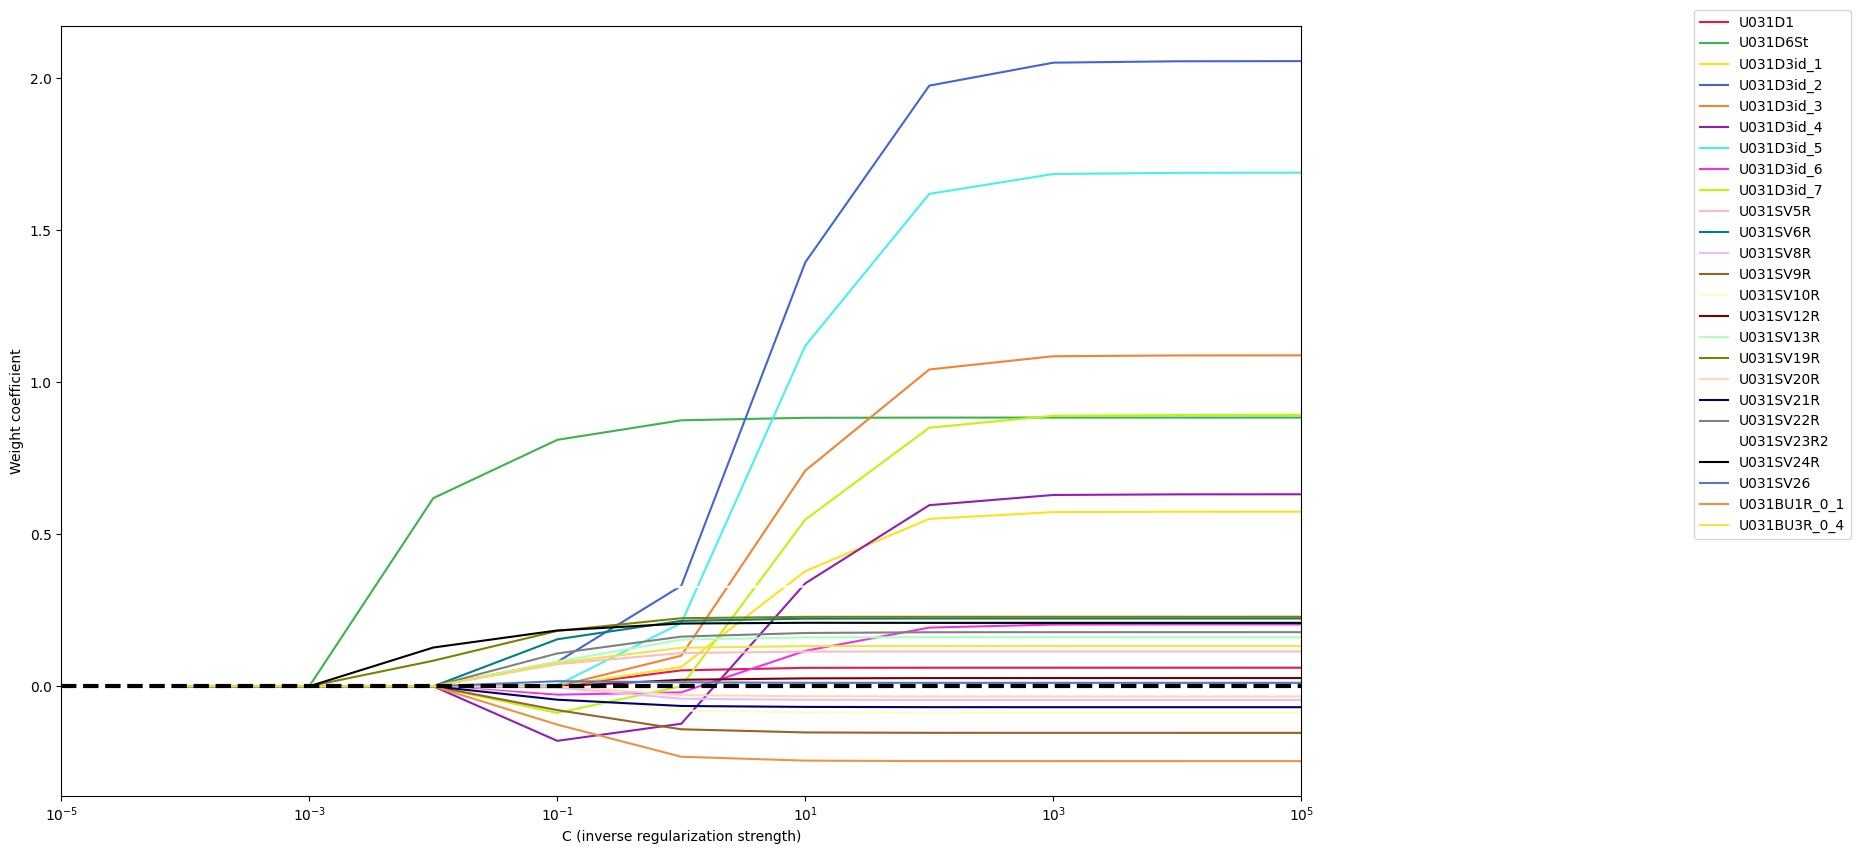

In [299]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 10))  # Width = 16 inches, Height = 810inches
ax = plt.subplot(111)  # Add subplot for layout

# 25 colors
colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
    '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
    '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
    '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',
    '#ffffff', '#000000', '#527bc7', '#f38f42', '#f0e442'
]

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, # we increaes the penalty 
                            solver='liblinear', #  
                            class_weight='balanced',
                             random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[0])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=data.columns[column + 1],
             color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)

#plt.savefig('figures/04_08.png', dpi=300, 
#            bbox_inches='tight', pad_inches=0.2)

plt.show()

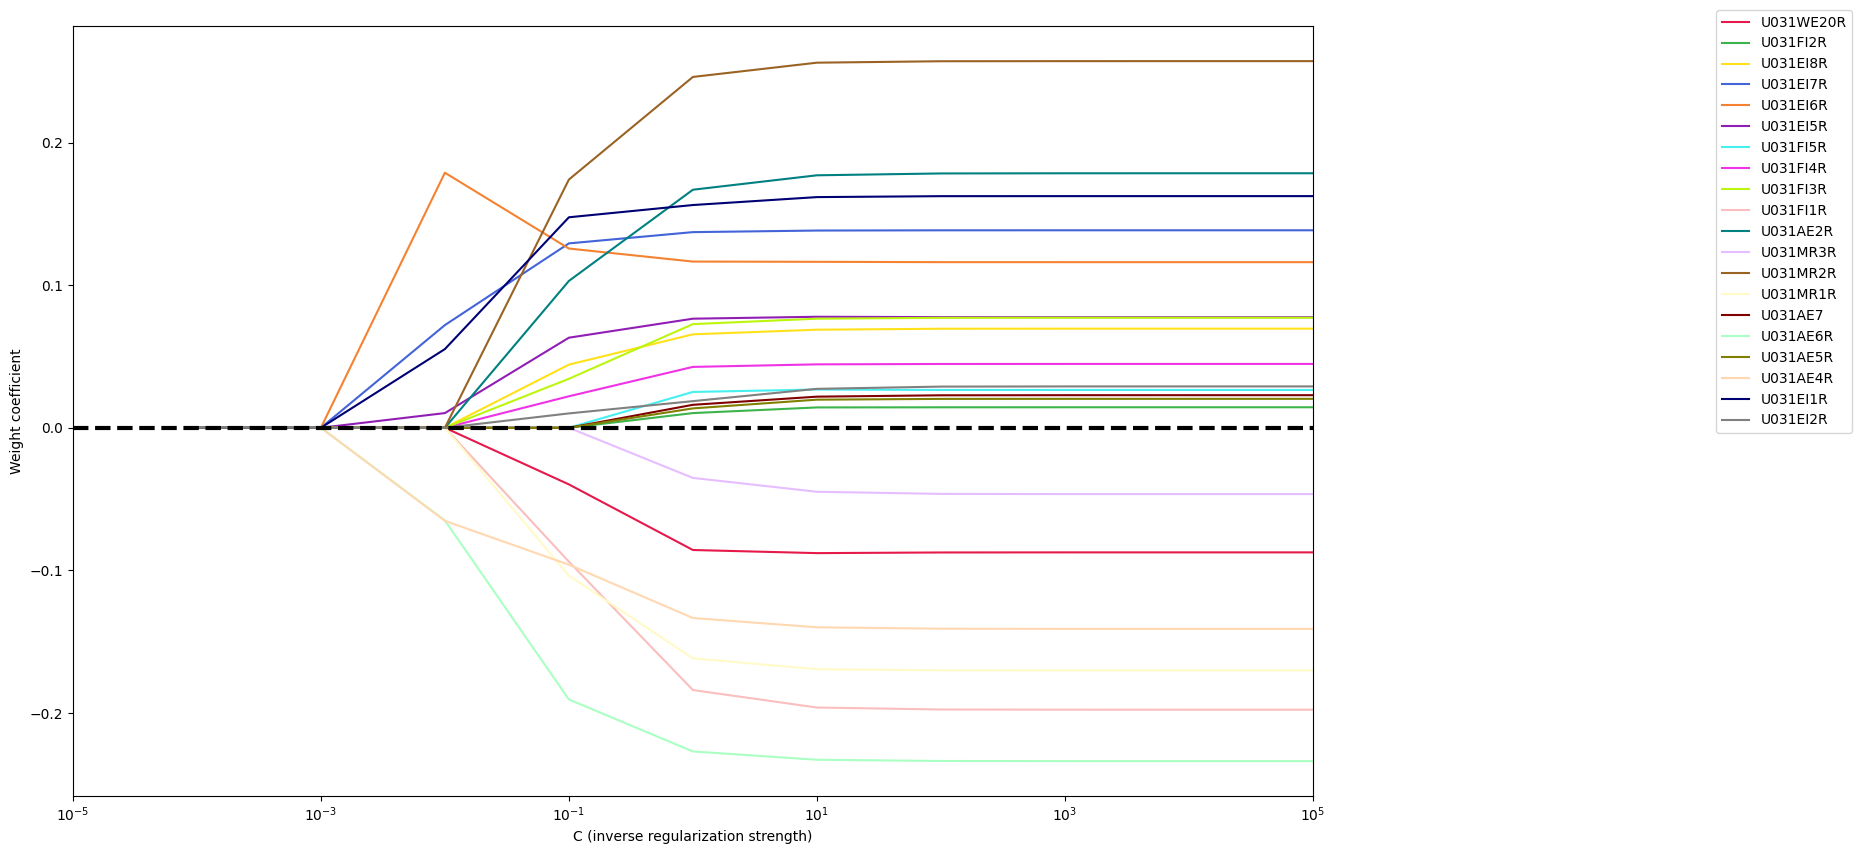

In [300]:
# only top 20 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 10))  # Width = 16 inches, Height = 810inches
ax = plt.subplot(111)

# 25 colors
colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
    '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
    '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
    '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',
    '#ffffff', '#000000', '#527bc7', '#f38f42', '#f0e442'
]

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c,
                            solver='liblinear',
                            class_weight='balanced',
                            random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[0])
    params.append(10**c)

weights = np.array(weights)

# Sort features by their absolute weight coefficients
sorted_feature_indices = np.argsort(np.abs(weights), axis=1)[:, ::-1]
top_feature_indices = sorted_feature_indices[:, :20]

# Extract the top 20 feature labels and save them into a list
L1_model = [data.columns[top_feature_indices[0][column] + 1] for column in range(20)]


# Plot the top 20 important features
for column, color in zip(range(20), colors):
    plt.plot(params, weights[:, top_feature_indices[0][column]],
             label=data.columns[top_feature_indices[0][column] + 1],
             color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)

plt.show()


In [301]:
L1_model

['U031WE20R',
 'U031FI2R',
 'U031EI8R',
 'U031EI7R',
 'U031EI6R',
 'U031EI5R',
 'U031FI5R',
 'U031FI4R',
 'U031FI3R',
 'U031FI1R',
 'U031AE2R',
 'U031MR3R',
 'U031MR2R',
 'U031MR1R',
 'U031AE7',
 'U031AE6R',
 'U031AE5R',
 'U031AE4R',
 'U031EI1R',
 'U031EI2R']

### Determining penalty score

You can also see how number of features vary across penalty scores

- Smaller C values enforce stronger regularization, resulting in fewer selected features.
- Larger C values reduce regularization, allowing more features to be included.
- This approach demonstrates how L1 regularization performs feature selection dynamically as regularization strength changes.

C=0.00010: Selected 0 features
C=0.00100: Selected 0 features
C=0.01000: Selected 23 features
C=0.10000: Selected 112 features
C=1.00000: Selected 148 features
C=10.00000: Selected 154 features
C=100.00000: Selected 154 features
C=1000.00000: Selected 154 features
C=10000.00000: Selected 154 features
C=100000.00000: Selected 154 features


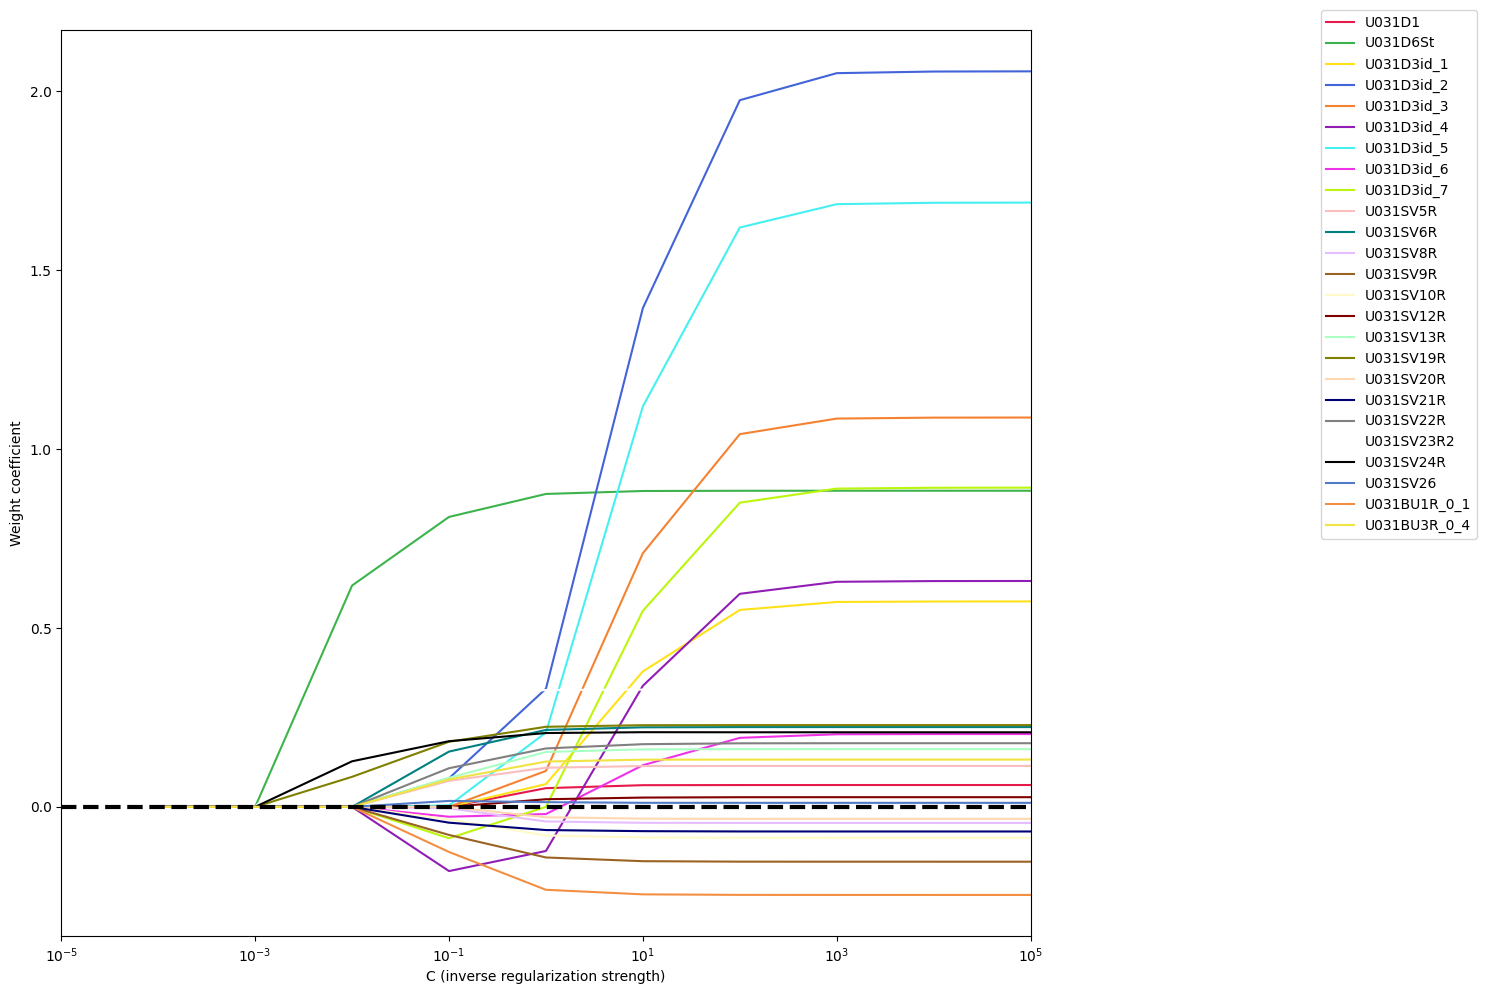

In [302]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

fig = plt.figure(figsize=(16, 10))  # Width = 16 inches, Height = 810inches
ax = plt.subplot(111)

# 25 colors
colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
    '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
    '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
    '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',
    '#ffffff', '#000000', '#527bc7', '#f38f42', '#f0e442'
]

weights, params = [], []
non_zero_counts = []  # To store the number of non-zero features

for c in np.arange(-4., 6.):  # Iterate over penalty values
    # Create and fit Logistic Regression with L1 regularization
    lr = LogisticRegression(penalty='l1', C=10.**c, # Increase penalty
                            solver='liblinear',  # Solver compatible with L1
                            class_weight='balanced',
                            random_state=0)
    lr.fit(X_train_std, y_train)  # Fit the model
    
    # Append coefficients and parameter values
    weights.append(lr.coef_[0])  # Store coefficients
    params.append(10**c)  # Store C values
    
    # Count non-zero coefficients (selected features)
    non_zero_count = np.sum(lr.coef_[0] != 0)  # Count non-zero coefficients
    non_zero_counts.append(non_zero_count)  # Track count
    
    # Print the number of features inferred for this C value
    print(f'C={10**c:.5f}: Selected {non_zero_count} features')

weights = np.array(weights)  # Convert weights to numpy array

# Plot the coefficients for each feature
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=data.columns[column + 1],  # Feature names
             color=color)

# Highlight plot details
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])  # Set x-axis range
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')  # Use log scale for C
plt.legend(loc='upper left')  # Legend for features
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)

plt.tight_layout()
plt.show()


## Feature importance with Random Forests 


Random Forest is an **ensemble learning algorithm** that combines multiple decision trees to improve predictive accuracy and reduce overfitting. It is also an **embedded method** for **feature selection**, as it evaluates feature importance during the model training process.  

In Random Forest, feature importance is calculated based on how much each feature contributes to reducing impurity (e.g., Gini impurity or entropy) when splitting nodes in the decision trees. Features with higher importance scores are considered more relevant for predicting the target variable.  

**Key Advantages of Using Random Forest for Feature Selection:**  
- **Embedded Approach:** Feature selection is seamlessly integrated into the training process, eliminating the need for separate preprocessing steps.  
- **Ensemble-Based Robustness:** By averaging results from multiple trees, it reduces variance and improves generalization, making it effective for handling non-linear relationships and noisy data.  
- **Handles Class Imbalance:** When combined with class weights, Random Forest accounts for class imbalances, ensuring fair evaluation of features.  
- **Scalable and Flexible:** It works well with high-dimensional data and can handle large feature sets without compromising performance.  

**Applications:**  
- **Dimensionality Reduction:** Reduces the number of input features, simplifying models and improving interpretability.  
- **Model Interpretation:** Provides insights into feature relevance, guiding further analysis and decision-making.  

The following implementation uses Random Forest as both a **predictive model** and an **embedded feature selection method** to rank features based on their importance scores.

In [303]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier  # Random Forest for classification
from sklearn.model_selection import StratifiedKFold  # Stratified 10-fold cross-validation

# Assuming 'data' is a DataFrame containing your dataset, and the features are in columns starting from the second column (index 1).
feat_labels = data.columns[1:]

# Create a RandomForestClassifier model with specific settings.
# - n_estimators: Number of decision trees in the forest.
# - class_weight: 'balanced' adjusts the weights of classes to account for class imbalance.
# - random_state: A seed for random number generation to ensure reproducibility.
forest = RandomForestClassifier(n_estimators=250, class_weight='balanced', random_state=1)

# Fit (train) the RandomForestClassifier using standardized training data.
forest.fit(X_train_std, y_train)

# Get the feature importances calculated by the RandomForestClassifier.
importances = forest.feature_importances_

# Sort the indices of features by their importance in descending order.
indices = np.argsort(importances)[::-1]


In [304]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) U031D6St                       0.066354
 2) U031SV23R2                     0.036735
 3) U031SE6R                       0.022027
 4) U031EI6R                       0.021108
 5) U031EI7R                       0.015156
 6) U031EI1R                       0.014907
 7) U031SV19R                      0.014450
 8) U031SV26                       0.012996
 9) U031WE26_8                     0.012620
10) U031FA1R                       0.012414
11) U031AE1R                       0.011237
12) U031CO1R                       0.011219
13) U031SV24R                      0.011033
14) U031AE4R                       0.010873
15) U031WE30R                      0.010801
16) U031EI2R                       0.010078
17) U031CR3R                       0.010006
18) U031EI4R                       0.009801
19) U031AE6R                       0.009716
20) U031WE13R                      0.009664
21) U031BU4R_0_4                   0.009025
22) U031WE8                        0.008702
23) U031SE5R                    

### Plot the important features

Once the regressor is fitted, the importance of the features is stored inside the feature_importances_ property of the estimator instance.

Let’s, for example, draw a bar chart with the features sorted from the most important to the less important. We’ll have to create a list of tuples. The first element of the tuple is the feature name, the second element is the importance. Then we order our list for importance value and plot a horizontal bar plot.

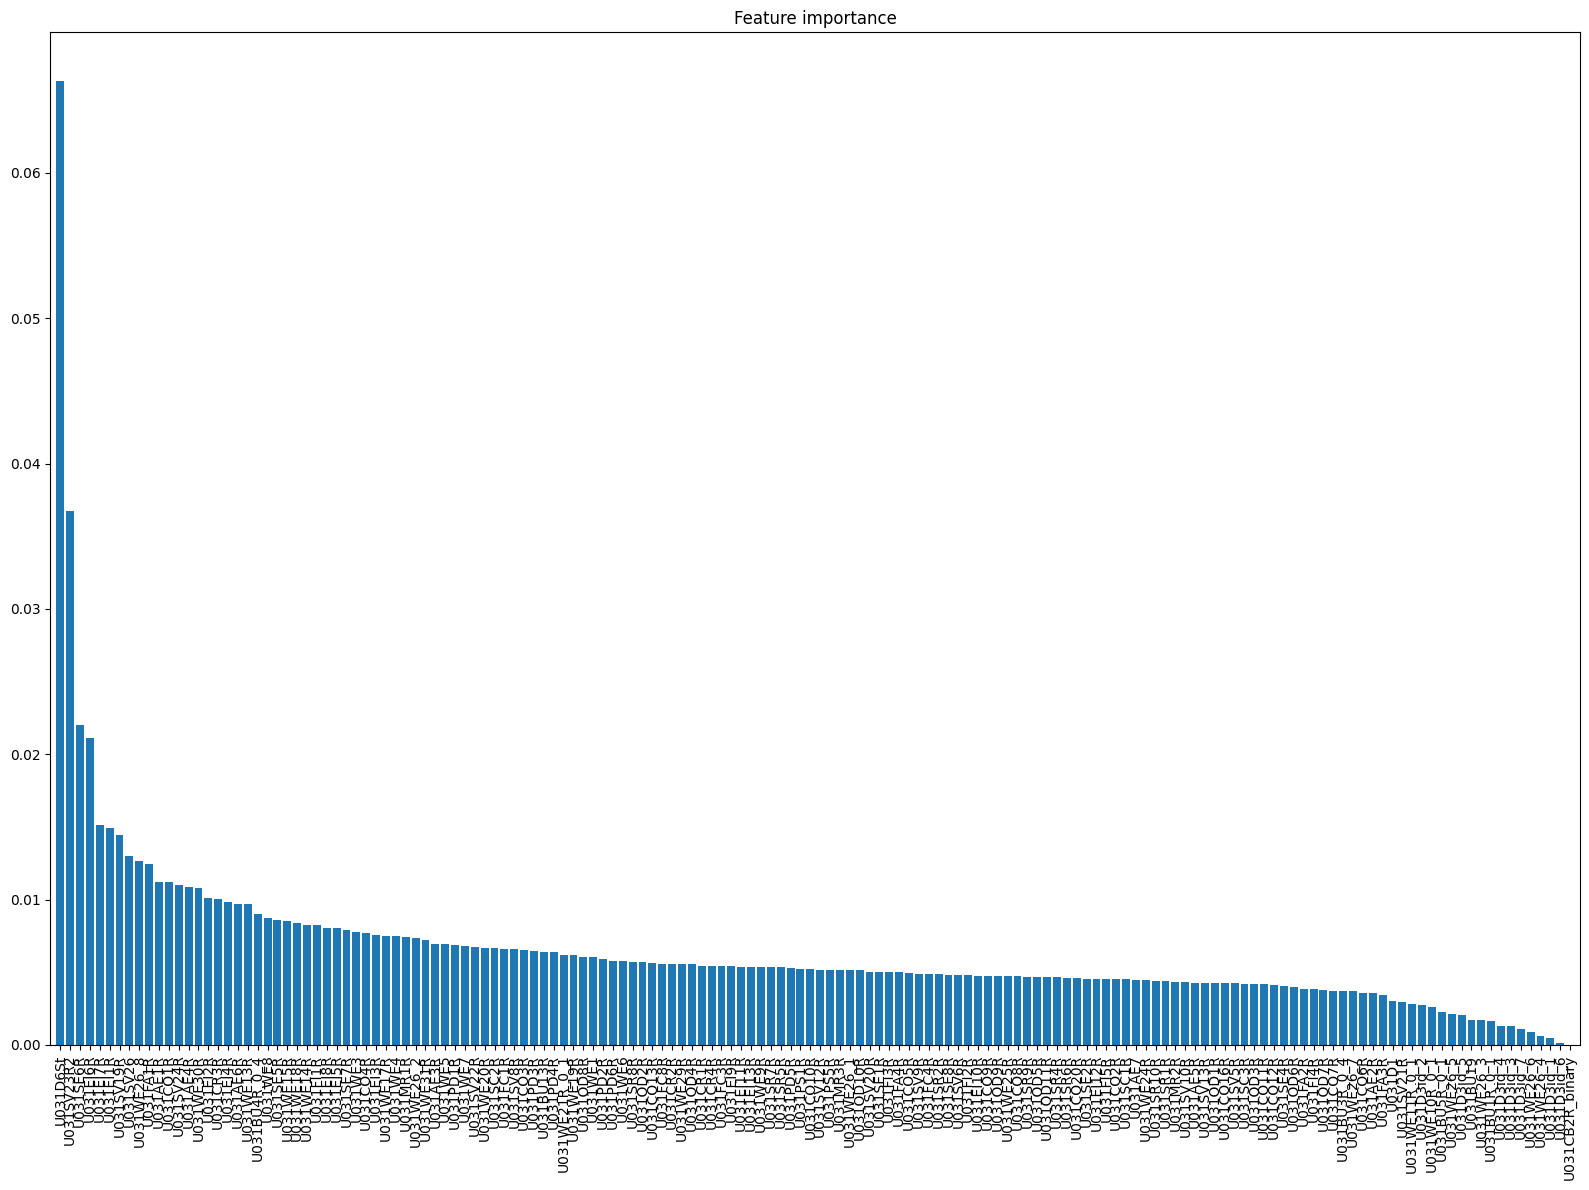

In [305]:
# Plot

from matplotlib.pyplot import figure
figure(figsize=(16, 12), dpi=100)


plt.title('Feature importance')
plt.bar(range(X_train_std.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train_std.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train_std.shape[1]])
plt.tight_layout()
# plt.savefig('figures/04_10.png', dpi=300)



plt.show()



In [306]:
# Import SelectFromModel for feature selection based on model importance scores
from sklearn.feature_selection import SelectFromModel

# Initialize SelectFromModel with a pre-trained model (forest) and a threshold
sfm = SelectFromModel(forest, threshold=0.01, prefit=True)
# forest: A pre-trained model, e.g., RandomForestClassifier or similar, used to compute feature importances
# threshold=0.01: Retain features with importance scores above 0.01
# prefit=True: Assumes the model (forest) is already trained, so we can directly use its feature importances

# Transform the training data to retain only the selected features
X_selected = sfm.transform(X_train_std)
# X_train_std: Standardized training data
# transform(): Applies the selection mask to keep only features that meet the threshold

# Print the number of features that meet the threshold criterion
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])
# X_selected.shape[1]: Retrieves the number of features retained after selection


Number of features that meet this threshold criterion: 17


In [307]:
# Initialize an empty list for feature labels
random_forest = []

# Assuming that your loop for printing feature importance is as follows
for f in range(X_selected.shape[1]):
    feature_label = feat_labels[indices[f]]
    importances_value = importances[indices[f]]
    print("%2d) %-*s %f" % (f + 1, 30, feature_label, importances_value))
    
    # Append the feature label to the 'random_forest' list
    random_forest.append(feature_label)

 1) U031D6St                       0.066354
 2) U031SV23R2                     0.036735
 3) U031SE6R                       0.022027
 4) U031EI6R                       0.021108
 5) U031EI7R                       0.015156
 6) U031EI1R                       0.014907
 7) U031SV19R                      0.014450
 8) U031SV26                       0.012996
 9) U031WE26_8                     0.012620
10) U031FA1R                       0.012414
11) U031AE1R                       0.011237
12) U031CO1R                       0.011219
13) U031SV24R                      0.011033
14) U031AE4R                       0.010873
15) U031WE30R                      0.010801
16) U031EI2R                       0.010078
17) U031CR3R                       0.010006


### Cross validation and class-balance

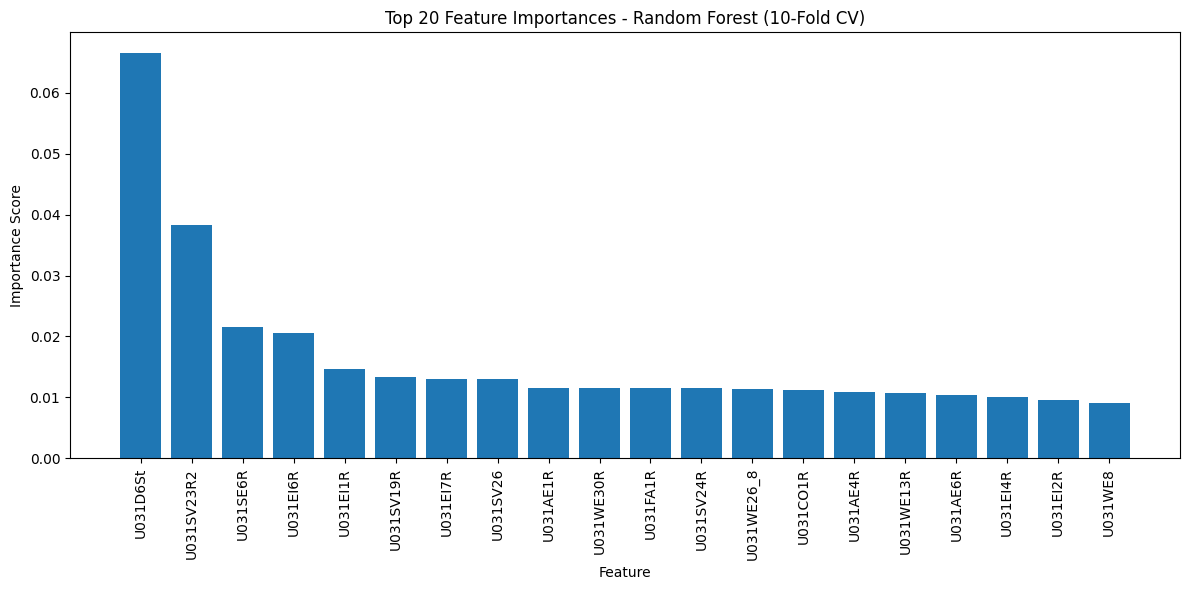

In [308]:
# 



# Retrieve feature labels (excluding the target variable)
feat_labels = data.columns[1:]

# Initialize Stratified 10-Fold Cross-Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Placeholder for feature importance scores
importances = np.zeros(X_train_std.shape[1])

# Perform 10-fold Cross-Validation
for train_index, test_index in kf.split(X_train_std, y_train):
    # Split data into training and validation folds
    X_train_fold, X_val_fold = X_train_std[train_index], X_train_std[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
    
    # Train a RandomForestClassifier with class weights
    forest = RandomForestClassifier(
        n_estimators=250,               # Number of trees in the forest
        class_weight='balanced',        # Handles class imbalance
        random_state=1                  # Ensures reproducibility
    )
    forest.fit(X_train_fold, y_train_fold)  # Train the model on the current fold
    
    # Accumulate feature importance scores across folds
    importances += forest.feature_importances_

# Average the importance scores over the 10 folds
importances /= kf.n_splits

# Sort features by importance scores in descending order
indices = np.argsort(importances)[::-1]  # Indices of sorted features
top_indices = indices[:20]  # Select indices for the top 20 features

# Get feature names for the top 20 features
top_features = feat_labels[top_indices]  # Retrieve feature names based on indices


# Visualization of feature importances
plt.figure(figsize=(12, 6))
plt.title('Top 20 Feature Importances - Random Forest (10-Fold CV)')
plt.bar(range(20), importances[top_indices], align='center')  # Bar plot for top 20
plt.xticks(range(20), top_features, rotation=90)  # Add feature names to x-axis
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


In [309]:

# Print the number of selected features and their names
print('Number of features selected:', len(top_features))
print('Top 20 features:', list(top_features))

Number of features selected: 20
Top 20 features: ['U031D6St', 'U031SV23R2', 'U031SE6R', 'U031EI6R', 'U031EI1R', 'U031SV19R', 'U031EI7R', 'U031SV26', 'U031AE1R', 'U031WE30R', 'U031FA1R', 'U031SV24R', 'U031WE26_8', 'U031CO1R', 'U031AE4R', 'U031WE13R', 'U031AE6R', 'U031EI4R', 'U031EI2R', 'U031WE8']


## Feature Selection with Decision Trees 

**Decision Trees** are a type of **embedded method** that can be used for **feature selection** by evaluating the importance of each feature during the model training process. Unlike filter or wrapper methods, decision trees naturally rank features based on how effectively they split the data to reduce impurity (e.g., **Gini impurity** or **entropy**) at each node.  

In feature selection, **Decision Trees** provide **importance scores** for each feature, which can be used to select the most relevant predictors and remove irrelevant or redundant ones. This method is especially useful for datasets with **non-linear relationships** and **interactions** between variables.  

**Key Advantages of Decision Trees for Feature Selection:**  
- **Embedded Approach:** Feature selection is integrated into the model training process, avoiding additional preprocessing steps.  
- **Handles Non-linear Relationships:** Captures complex patterns without requiring linear assumptions.  
- **Scalable and Efficient:** Suitable for high-dimensional datasets and handles both numerical and categorical data effectively.  
- **Robust to Missing Data:** Decision trees can handle datasets with missing values without requiring imputation.  

**Applications:**  
- **Dimensionality Reduction:** Simplifies models by reducing the number of features, improving interpretability and computational efficiency.  
- **Baseline Feature Ranking:** Serves as a quick and interpretable method for evaluating feature importance before applying more complex models.  



Number of features selected: 20
Top 20 features: ['U031SV23R2', 'U031D6St', 'U031SV19R', 'U031MR2R', 'U031AE5R', 'U031SV24R', 'U031EI6R', 'U031BU4R_0_4', 'U031SR7R', 'U031CR3R', 'U031WE3', 'U031CO6R', 'U031PD6R', 'U031CO11R', 'U031SV22R', 'U031EI9R', 'U031WE6', 'U031CO9R', 'U031WE11R_0_1', 'U031SR5R']


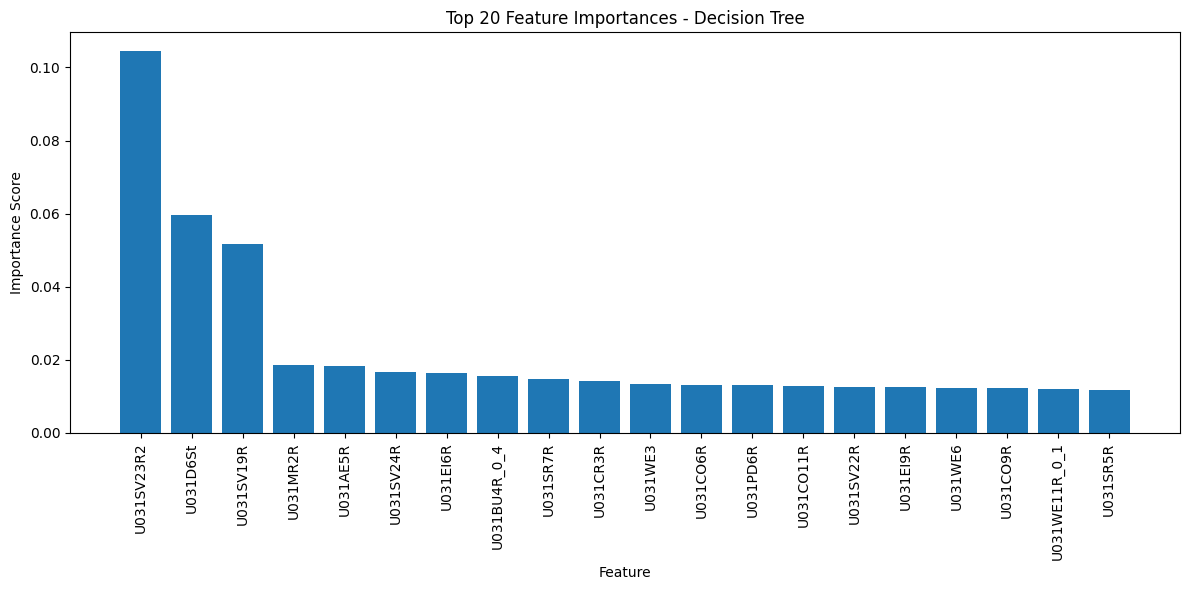

In [310]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier  # Decision Tree for classification
from sklearn.feature_selection import SelectFromModel  # Feature selection tool
import matplotlib.pyplot as plt
import numpy as np

# Train a Decision Tree model
tree = DecisionTreeClassifier(criterion='gini', random_state=42)  # Using Gini impurity
tree.fit(X_train_std, y_train)  # Fit the model on standardized training data

# Feature importance scores
importances = tree.feature_importances_  # Extract importance scores for each feature

# Sort features by importance scores in descending order
indices = np.argsort(importances)[::-1]  # Indices of sorted features
top_indices = indices[:20]  # Select indices for the top 20 features

# Get feature names for the top 20 features
top_features = data.columns[1:][top_indices]  # Exclude the target variable

# Reduce data to the top 20 features
X_selected = X_train_std[:, top_indices]  # Select columns based on top 20 indices

# Print the number of selected features and their names
print('Number of features selected:', len(top_features))
print('Top 20 features:', list(top_features))

# Visualization of feature importances
plt.figure(figsize=(12, 6))
plt.title('Top 20 Feature Importances - Decision Tree')
plt.bar(range(20), importances[top_indices], align='center')  # Bar plot for top 20
plt.xticks(range(20), top_features, rotation=90)  # Add feature names to x-axis
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


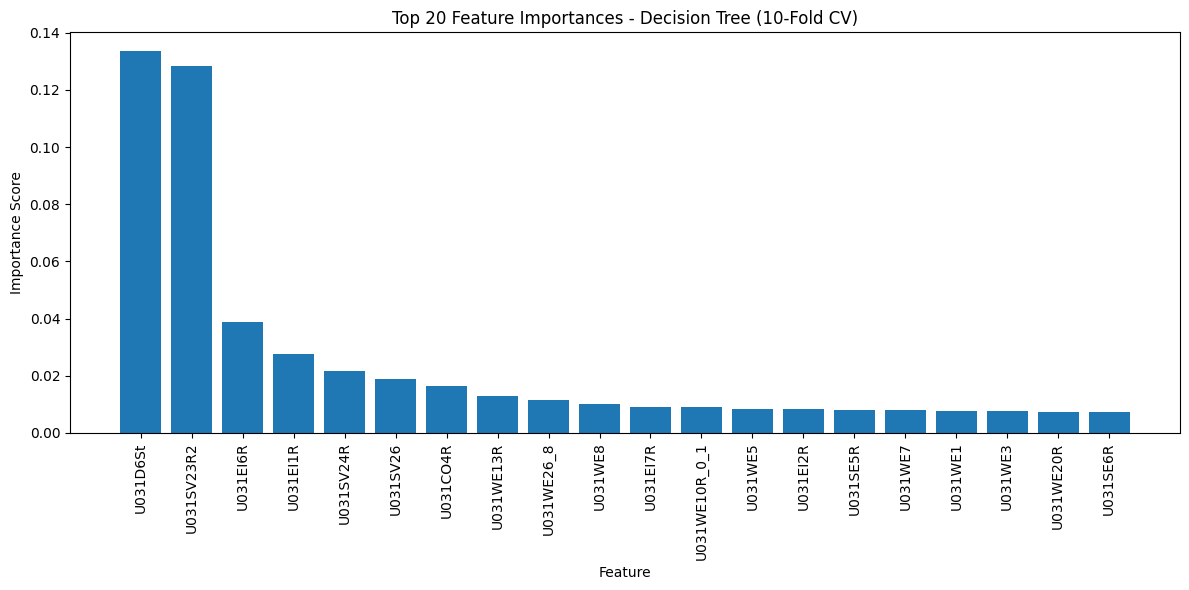

In [311]:
# now considering 10 fold cross validation and class weight in calculation

# Initialize Stratified 10-Fold Cross-Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Placeholder for feature importance scores
importances = np.zeros(X_train_std.shape[1])

# Perform 10-fold Cross-Validation
for train_index, test_index in kf.split(X_train_std, y_train):
    # Split data into training and validation folds
    X_train_fold, X_val_fold = X_train_std[train_index], X_train_std[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
    
    # Train a Decision Tree model with class weights to handle imbalance
    tree = DecisionTreeClassifier(criterion='gini', 
                                  class_weight='balanced',  # Handles class imbalance
                                  random_state=42)
    tree.fit(X_train_fold, y_train_fold)  # Fit the model on the training fold
    
    # Accumulate feature importance scores across folds
    importances += tree.feature_importances_

# Average the importance scores over the 10 folds
importances /= kf.n_splits

# Sort features by importance scores in descending order
indices = np.argsort(importances)[::-1]  # Indices of sorted features
top_indices = indices[:20]  # Select indices for the top 20 features

# Get feature names for the top 20 features
top_features = data.columns[1:][top_indices]  # Exclude the target variable

# Reduce data to the top 20 features
X_selected = X_train_std[:, top_indices]  # Select columns based on top 20 indices


# Visualization of feature importances
plt.figure(figsize=(12, 6))
plt.title('Top 20 Feature Importances - Decision Tree (10-Fold CV)')
plt.bar(range(20), importances[top_indices], align='center')  # Bar plot for top 20
plt.xticks(range(20), top_features, rotation=90)  # Add feature names to x-axis
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


In [312]:
# Print the number of selected features and their names
print('Number of features selected:', len(top_features))
print('Top 20 features:', list(top_features))


Number of features selected: 20
Top 20 features: ['U031D6St', 'U031SV23R2', 'U031EI6R', 'U031EI1R', 'U031SV24R', 'U031SV26', 'U031CO4R', 'U031WE13R', 'U031WE26_8', 'U031WE8', 'U031EI7R', 'U031WE10R_0_1', 'U031WE5', 'U031EI2R', 'U031SE5R', 'U031WE7', 'U031WE1', 'U031WE3', 'U031WE20R', 'U031SE6R']


# Summary

In this analysis, we explored several **feature selection methods** to identify the most relevant features for modeling. Feature selection helps reduce **dimensionality**, improves **model performance**, and enhances **interpretability**. Each method has its own **advantages and limitations**, making it important to evaluate results carefully, especially in the context of the problem domain.



### **Key Methods Explored:**  

1. **Variance Thresholding (Filter Method):**  
   - **Purpose:** Removes features with low variance, assuming they have little predictive power.  
   - **Advantage:** Simple, fast, and computationally efficient.  
   - **Limitation:** Does not consider relationships between features and the target variable, potentially overlooking important patterns.  

2. **K-Best with ANOVA F-value (Filter Method):**  
   - **Purpose:** Selects features based on their statistical relationship with the target variable using the **F-statistic**.  
   - **Advantage:** Suitable for datasets with **numerical inputs** and **categorical outputs**; easy to interpret.  
   - **Limitation:** Assumes **linear relationships** and may miss complex patterns that require more advanced models.  

3. **Information Gain (Mutual Information - Filter Method):**  
   - **Purpose:** Measures the dependency between each feature and the target variable, selecting features that provide the most **information gain**.  
   - **Advantage:** Captures **non-linear relationships** and works well with both numerical and categorical features.  
   - **Limitation:** Computationally expensive for very large datasets and may overfit without **cross-validation**.  

4. **Decision Trees (Embedded Method):**  
   - **Purpose:** Uses **Gini impurity** or **entropy** to rank features based on their importance during splits.  
   - **Advantage:** Handles **non-linear relationships** and **interactions** effectively; directly provides feature importance scores.  
   - **Limitation:** Sensitive to **hyperparameters** and **overfitting** without **cross-validation** and class balancing.  

5. **Random Forest (Embedded Method):**  
   - **Purpose:** Evaluates feature importance based on how much each feature reduces impurity across multiple decision trees.  
   - **Advantage:** Robust to overfitting and captures **non-linear relationships**; provides stable feature rankings.  
   - **Limitation:** Computationally expensive and may require tuning of hyperparameters for better performance.  

6. **L1 Regularization (Embedded Method):**  
   - **Purpose:** Shrinks coefficients in a **Logistic Regression** model, forcing irrelevant features' coefficients to **zero**.  
   - **Advantage:** Produces **sparse solutions**, simplifying the model and making it interpretable.  
   - **Limitation:** Assumes **linear relationships** and may not capture **non-linear dependencies** effectively.  

---

### **Impact of Cross-Validation and Class Imbalance:**  

**1. Cross-Validation:**  
We incorporated **10-fold cross-validation** to improve reliability and **stability** of results.  
- **Why Important?** Ensures that feature selection is **consistent** across different subsets of data, reducing variability and overfitting caused by a single train-test split.  
- **Limitation:** Computationally more intensive but provides a more **robust feature ranking**.  

**2. Class Imbalance:**  
We accounted for **class imbalance** using **class weights ('balanced')** in models like **Decision Trees** and **Random Forests**.  
- **Why Important?** Prevents the model from favoring the majority class by assigning higher weights to minority classes.  
- **Limitation:** Class weights address imbalance during training but do not **alter data distribution**. For more advanced techniques, methods like **SMOTE (Synthetic Minority Over-sampling Technique)** and **downsampling** can be explored.  

---

### **Interpreting Feature Selection Results:**  

Feature selection methods should be seen as **initial screening tools** rather than definitive solutions. The results help **identify potential directions** for further investigation.  

**Key Recommendations:**  
1. **Domain Knowledge Validation:**  
   - Always validate selected features using **domain-specific insights** to ensure their practical relevance.  

2. **Combining Methods:**  
   - Merge features selected by **multiple methods** to ensure robustness and account for **different feature relationships** (linear, non-linear).  

3. **Advanced Techniques:**  
   - Use more advanced methods like **Recursive Feature Elimination (RFE)**, **SHAP values**, and **Permutation Importance** for deeper evaluation of feature relevance.  

---

### **Next Steps and Recommendations:**  

1. **Advanced Feature Engineering and Selection:**  
   - Test techniques like **SMOTE** for oversampling minority classes, **undersampling**, or **balanced bagging** to handle class imbalance more effectively.  
   - Implement methods like **Gradient Boosting** or **XGBoost**, which combine boosting with embedded feature selection.  

2. **Model-Specific Evaluations:**  
   - Fit multiple models (**Logistic Regression**, **SVM**, **Random Forest**, etc.) to evaluate performance based on selected features and compare results.  

3. **Domain-Specific Validation:**  
   - Incorporate insights from the field to validate whether selected features align with theoretical expectations or empirical findings.  

4. **Pipeline Optimization:**  
   - Develop a full **machine learning pipeline** that includes preprocessing, sampling, feature selection, model training, and evaluation to streamline the process.  

---

### **Final Thoughts:**  

The methods explored here provide **baseline feature selection** approaches to **narrow down candidate features** for further investigation. However, feature selection is only the **first step** in building a robust predictive model.  

For more complex datasets and imbalanced problems, advanced techniques like **SMOTE**, **RFE**, **SHAP values**, and **ensemble approaches** can be incorporated. It is also essential to **combine domain expertise** with data-driven insights to ensure that the selected features are both **statistically significant** and **practically relevant**.  

